# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [167]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [174]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = y
        a = self._fit_predict_tree(x, y)
        for i in range(self.n_estimators):
            y_new = y - a
            b = self._fit_predict_tree(x, y_new)
            self.gamma = minimize(lambda x: np.mean(y - a - x * b / self.learning_rate) ** 2, -1).x
            a += b

    def _fit_predict_tree(self, x, y):
        
        # Обучаем дерево и возвращаем его предикшн
        # your code here
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth, criterion = "mse")
        tree.fit(x, y)
        self.trees.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        
        y_pred = np.ones([x.shape[0]]) * np.mean(y)
        for i in range(self.n_estimators):
            y_pred += self.learning_rate * self.trees[i].predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [175]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [176]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [177]:
np.random.seed(19052019)

# your code here
gb = GradientBoosting(30, 1, 0.1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [178]:
mean_squared_error(y_test, y_pred)

513.9699426826053

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да, но что-то не очень получилось

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Уберу все warnings для красоты

In [6]:
import warnings
warnings.filterwarnings("ignore")

Буду использовать catboost

In [7]:
import catboost

Подготовлю данные

In [38]:
y = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
X = train.drop('dep_delayed_15min', axis=1)

Создаю список категориальных фичей

In [18]:
cat_features = [0, 1, 2, 4, 5, 6] # убрала индексы столбцов DepTime и Distance

Анализирую соотношение классов

In [42]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 80956, One count = 19044


In [21]:
from catboost import Pool, FeaturesData

Создаю Pool-объект

In [43]:
X_prepared = X.values.astype(str).astype(object)

pool = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print(str(pool.shape))
print('\nColumn names')
print(pool.get_feature_names())

Dataset shape
(100000, 8)

Column names
['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance']


Разобью данные на train и validation

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

Обучение и нахождение roc-auc с помощью gridsearch

In [68]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(CatBoostClassifier(),
                       {'n_estimators': [100, 200], 'max_depth': [2, 3], 'learning_rate':[0.05, 0.1, 0.3]},
                       scoring='roc_auc')

gscv.fit(X_train, y_train, cat_features=cat_features,
    eval_set=(X_valid, y_valid))
print(gscv.best_score_, gscv.best_params_)

0:	learn: 0.6730472	test: 0.6731291	best: 0.6731291 (0)	total: 14ms	remaining: 1.39s
1:	learn: 0.6547042	test: 0.6548541	best: 0.6548541 (1)	total: 26.9ms	remaining: 1.32s
2:	learn: 0.6380792	test: 0.6382860	best: 0.6382860 (2)	total: 35.8ms	remaining: 1.16s
3:	learn: 0.6230783	test: 0.6233594	best: 0.6233594 (3)	total: 43.7ms	remaining: 1.05s
4:	learn: 0.6093090	test: 0.6096188	best: 0.6096188 (4)	total: 51.5ms	remaining: 979ms
5:	learn: 0.5966881	test: 0.5970138	best: 0.5970138 (5)	total: 63.2ms	remaining: 990ms
6:	learn: 0.5853967	test: 0.5857558	best: 0.5857558 (6)	total: 70.6ms	remaining: 938ms
7:	learn: 0.5748437	test: 0.5752230	best: 0.5752230 (7)	total: 79ms	remaining: 909ms
8:	learn: 0.5654803	test: 0.5659188	best: 0.5659188 (8)	total: 87.5ms	remaining: 885ms
9:	learn: 0.5566410	test: 0.5570918	best: 0.5570918 (9)	total: 95.1ms	remaining: 856ms
10:	learn: 0.5485291	test: 0.5490308	best: 0.5490308 (10)	total: 106ms	remaining: 857ms
11:	learn: 0.5411537	test: 0.5416709	best: 0.5

95:	learn: 0.4469520	test: 0.4480122	best: 0.4480122 (95)	total: 1.07s	remaining: 44.5ms
96:	learn: 0.4468578	test: 0.4479577	best: 0.4479577 (96)	total: 1.08s	remaining: 33.4ms
97:	learn: 0.4468013	test: 0.4478912	best: 0.4478912 (97)	total: 1.1s	remaining: 22.4ms
98:	learn: 0.4466856	test: 0.4477896	best: 0.4477896 (98)	total: 1.11s	remaining: 11.2ms
99:	learn: 0.4466201	test: 0.4477300	best: 0.4477300 (99)	total: 1.12s	remaining: 0us

bestTest = 0.447729989
bestIteration = 99

0:	learn: 0.6730175	test: 0.6730884	best: 0.6730884 (0)	total: 27.1ms	remaining: 2.69s
1:	learn: 0.6546679	test: 0.6547953	best: 0.6547953 (1)	total: 38.9ms	remaining: 1.91s
2:	learn: 0.6380235	test: 0.6382161	best: 0.6382161 (2)	total: 46.4ms	remaining: 1.5s
3:	learn: 0.6230088	test: 0.6232771	best: 0.6232771 (3)	total: 54.5ms	remaining: 1.31s
4:	learn: 0.6092079	test: 0.6095169	best: 0.6095169 (4)	total: 62.4ms	remaining: 1.19s
5:	learn: 0.5965926	test: 0.5969153	best: 0.5969153 (5)	total: 74.6ms	remaining: 

0:	learn: 0.6728944	test: 0.6729551	best: 0.6729551 (0)	total: 15.5ms	remaining: 1.54s
1:	learn: 0.6545456	test: 0.6546762	best: 0.6546762 (1)	total: 31ms	remaining: 1.52s
2:	learn: 0.6379248	test: 0.6381252	best: 0.6381252 (2)	total: 39.7ms	remaining: 1.28s
3:	learn: 0.6228948	test: 0.6231804	best: 0.6231804 (3)	total: 50.5ms	remaining: 1.21s
4:	learn: 0.6090993	test: 0.6094265	best: 0.6094265 (4)	total: 59.5ms	remaining: 1.13s
5:	learn: 0.5964723	test: 0.5968288	best: 0.5968288 (5)	total: 73.3ms	remaining: 1.15s
6:	learn: 0.5851593	test: 0.5855581	best: 0.5855581 (6)	total: 82.7ms	remaining: 1.1s
7:	learn: 0.5745854	test: 0.5750259	best: 0.5750259 (7)	total: 91.3ms	remaining: 1.05s
8:	learn: 0.5651682	test: 0.5656423	best: 0.5656423 (8)	total: 100ms	remaining: 1.01s
9:	learn: 0.5563180	test: 0.5568134	best: 0.5568134 (9)	total: 108ms	remaining: 975ms
10:	learn: 0.5482031	test: 0.5487599	best: 0.5487599 (10)	total: 117ms	remaining: 949ms
11:	learn: 0.5408277	test: 0.5414121	best: 0.54

0:	learn: 0.6729339	test: 0.6729657	best: 0.6729657 (0)	total: 12.7ms	remaining: 1.26s
1:	learn: 0.6546101	test: 0.6546966	best: 0.6546966 (1)	total: 24.1ms	remaining: 1.18s
2:	learn: 0.6380226	test: 0.6381567	best: 0.6381567 (2)	total: 31.6ms	remaining: 1.02s
3:	learn: 0.6230239	test: 0.6232305	best: 0.6232305 (3)	total: 39ms	remaining: 935ms
4:	learn: 0.6092696	test: 0.6094993	best: 0.6094993 (4)	total: 46.9ms	remaining: 891ms
5:	learn: 0.5966818	test: 0.5969127	best: 0.5969127 (5)	total: 64.8ms	remaining: 1.01s
6:	learn: 0.5854025	test: 0.5856556	best: 0.5856556 (6)	total: 75.4ms	remaining: 1s
7:	learn: 0.5748495	test: 0.5751200	best: 0.5751200 (7)	total: 84.8ms	remaining: 975ms
8:	learn: 0.5654784	test: 0.5658030	best: 0.5658030 (8)	total: 92.4ms	remaining: 934ms
9:	learn: 0.5566738	test: 0.5570298	best: 0.5570298 (9)	total: 99.6ms	remaining: 897ms
10:	learn: 0.5485796	test: 0.5489720	best: 0.5489720 (10)	total: 107ms	remaining: 868ms
11:	learn: 0.5412101	test: 0.5416138	best: 0.54

0:	learn: 0.6728924	test: 0.6729472	best: 0.6729472 (0)	total: 14.7ms	remaining: 1.46s
1:	learn: 0.6545413	test: 0.6546562	best: 0.6546562 (1)	total: 26.2ms	remaining: 1.28s
2:	learn: 0.6379203	test: 0.6380964	best: 0.6380964 (2)	total: 34ms	remaining: 1.1s
3:	learn: 0.6228825	test: 0.6231558	best: 0.6231558 (3)	total: 42ms	remaining: 1.01s
4:	learn: 0.6090782	test: 0.6094004	best: 0.6094004 (4)	total: 49.6ms	remaining: 942ms
5:	learn: 0.5964493	test: 0.5967905	best: 0.5967905 (5)	total: 61ms	remaining: 955ms
6:	learn: 0.5851462	test: 0.5855251	best: 0.5855251 (6)	total: 68.3ms	remaining: 908ms
7:	learn: 0.5745962	test: 0.5750049	best: 0.5750049 (7)	total: 76ms	remaining: 874ms
8:	learn: 0.5651627	test: 0.5656160	best: 0.5656160 (8)	total: 83.4ms	remaining: 844ms
9:	learn: 0.5563013	test: 0.5567757	best: 0.5567757 (9)	total: 91.6ms	remaining: 824ms
10:	learn: 0.5481803	test: 0.5487247	best: 0.5487247 (10)	total: 109ms	remaining: 884ms
11:	learn: 0.5409451	test: 0.5415293	best: 0.541529

0:	learn: 0.6670856	test: 0.6671690	best: 0.6671690 (0)	total: 33.8ms	remaining: 6.73s
1:	learn: 0.6441118	test: 0.6441969	best: 0.6441969 (1)	total: 61.5ms	remaining: 6.09s
2:	learn: 0.6238702	test: 0.6240017	best: 0.6240017 (2)	total: 102ms	remaining: 6.72s
3:	learn: 0.6055199	test: 0.6057016	best: 0.6057016 (3)	total: 125ms	remaining: 6.11s
4:	learn: 0.5891648	test: 0.5894233	best: 0.5894233 (4)	total: 154ms	remaining: 6.02s
5:	learn: 0.5745649	test: 0.5747954	best: 0.5747954 (5)	total: 177ms	remaining: 5.71s
6:	learn: 0.5622138	test: 0.5625316	best: 0.5625316 (6)	total: 199ms	remaining: 5.48s
7:	learn: 0.5505669	test: 0.5508921	best: 0.5508921 (7)	total: 223ms	remaining: 5.36s
8:	learn: 0.5409775	test: 0.5413776	best: 0.5413776 (8)	total: 271ms	remaining: 5.76s
9:	learn: 0.5322574	test: 0.5326676	best: 0.5326676 (9)	total: 294ms	remaining: 5.58s
10:	learn: 0.5239080	test: 0.5243342	best: 0.5243342 (10)	total: 316ms	remaining: 5.42s
11:	learn: 0.5171174	test: 0.5174791	best: 0.51747

96:	learn: 0.4434948	test: 0.4440702	best: 0.4440702 (96)	total: 2.92s	remaining: 3.11s
97:	learn: 0.4434115	test: 0.4439878	best: 0.4439878 (97)	total: 2.99s	remaining: 3.11s
98:	learn: 0.4433288	test: 0.4438866	best: 0.4438866 (98)	total: 3.02s	remaining: 3.09s
99:	learn: 0.4431758	test: 0.4437199	best: 0.4437199 (99)	total: 3.06s	remaining: 3.06s
100:	learn: 0.4430822	test: 0.4436314	best: 0.4436314 (100)	total: 3.1s	remaining: 3.04s
101:	learn: 0.4429625	test: 0.4435053	best: 0.4435053 (101)	total: 3.16s	remaining: 3.04s
102:	learn: 0.4428877	test: 0.4434113	best: 0.4434113 (102)	total: 3.19s	remaining: 3s
103:	learn: 0.4427876	test: 0.4433246	best: 0.4433246 (103)	total: 3.23s	remaining: 2.98s
104:	learn: 0.4426690	test: 0.4431269	best: 0.4431269 (104)	total: 3.26s	remaining: 2.95s
105:	learn: 0.4425683	test: 0.4429571	best: 0.4429571 (105)	total: 3.29s	remaining: 2.92s
106:	learn: 0.4425023	test: 0.4428964	best: 0.4428964 (106)	total: 3.32s	remaining: 2.88s
107:	learn: 0.4424302	

189:	learn: 0.4371465	test: 0.4370786	best: 0.4370786 (189)	total: 7.23s	remaining: 381ms
190:	learn: 0.4370654	test: 0.4370134	best: 0.4370134 (190)	total: 7.32s	remaining: 345ms
191:	learn: 0.4370222	test: 0.4369692	best: 0.4369692 (191)	total: 7.35s	remaining: 306ms
192:	learn: 0.4369924	test: 0.4369445	best: 0.4369445 (192)	total: 7.4s	remaining: 268ms
193:	learn: 0.4369736	test: 0.4369324	best: 0.4369324 (193)	total: 7.47s	remaining: 231ms
194:	learn: 0.4369288	test: 0.4368776	best: 0.4368776 (194)	total: 7.51s	remaining: 193ms
195:	learn: 0.4369069	test: 0.4368546	best: 0.4368546 (195)	total: 7.56s	remaining: 154ms
196:	learn: 0.4368698	test: 0.4368091	best: 0.4368091 (196)	total: 7.59s	remaining: 116ms
197:	learn: 0.4368414	test: 0.4367939	best: 0.4367939 (197)	total: 7.64s	remaining: 77.2ms
198:	learn: 0.4367586	test: 0.4366733	best: 0.4366733 (198)	total: 7.68s	remaining: 38.6ms
199:	learn: 0.4367467	test: 0.4366652	best: 0.4366652 (199)	total: 7.71s	remaining: 0us

bestTest =

82:	learn: 0.4444745	test: 0.4458016	best: 0.4458016 (82)	total: 2.48s	remaining: 3.5s
83:	learn: 0.4443383	test: 0.4456981	best: 0.4456981 (83)	total: 2.51s	remaining: 3.46s
84:	learn: 0.4442518	test: 0.4456340	best: 0.4456340 (84)	total: 2.53s	remaining: 3.42s
85:	learn: 0.4441400	test: 0.4455446	best: 0.4455446 (85)	total: 2.54s	remaining: 3.37s
86:	learn: 0.4440647	test: 0.4454777	best: 0.4454777 (86)	total: 2.56s	remaining: 3.33s
87:	learn: 0.4439661	test: 0.4454005	best: 0.4454005 (87)	total: 2.58s	remaining: 3.29s
88:	learn: 0.4438595	test: 0.4453102	best: 0.4453102 (88)	total: 2.6s	remaining: 3.24s
89:	learn: 0.4437015	test: 0.4450844	best: 0.4450844 (89)	total: 2.62s	remaining: 3.2s
90:	learn: 0.4436281	test: 0.4450341	best: 0.4450341 (90)	total: 2.64s	remaining: 3.16s
91:	learn: 0.4435127	test: 0.4449085	best: 0.4449085 (91)	total: 2.65s	remaining: 3.12s
92:	learn: 0.4434253	test: 0.4448157	best: 0.4448157 (92)	total: 2.67s	remaining: 3.08s
93:	learn: 0.4431339	test: 0.444554

178:	learn: 0.4366448	test: 0.4375916	best: 0.4375916 (178)	total: 5.28s	remaining: 619ms
179:	learn: 0.4366019	test: 0.4375414	best: 0.4375414 (179)	total: 5.34s	remaining: 594ms
180:	learn: 0.4365793	test: 0.4375285	best: 0.4375285 (180)	total: 5.38s	remaining: 564ms
181:	learn: 0.4365448	test: 0.4374909	best: 0.4374909 (181)	total: 5.4s	remaining: 534ms
182:	learn: 0.4365077	test: 0.4374584	best: 0.4374584 (182)	total: 5.42s	remaining: 504ms
183:	learn: 0.4364704	test: 0.4374106	best: 0.4374106 (183)	total: 5.51s	remaining: 479ms
184:	learn: 0.4364374	test: 0.4373861	best: 0.4373861 (184)	total: 5.54s	remaining: 449ms
185:	learn: 0.4364221	test: 0.4373750	best: 0.4373750 (185)	total: 5.58s	remaining: 420ms
186:	learn: 0.4364077	test: 0.4373674	best: 0.4373674 (186)	total: 5.62s	remaining: 391ms
187:	learn: 0.4363132	test: 0.4372656	best: 0.4372656 (187)	total: 5.64s	remaining: 360ms
188:	learn: 0.4362659	test: 0.4372241	best: 0.4372241 (188)	total: 5.67s	remaining: 330ms
189:	learn:

77:	learn: 0.4445523	test: 0.4460316	best: 0.4460316 (77)	total: 2.19s	remaining: 3.42s
78:	learn: 0.4444425	test: 0.4459379	best: 0.4459379 (78)	total: 2.22s	remaining: 3.4s
79:	learn: 0.4442233	test: 0.4457199	best: 0.4457199 (79)	total: 2.26s	remaining: 3.39s
80:	learn: 0.4441458	test: 0.4456344	best: 0.4456344 (80)	total: 2.29s	remaining: 3.36s
81:	learn: 0.4440667	test: 0.4455616	best: 0.4455616 (81)	total: 2.3s	remaining: 3.31s
82:	learn: 0.4439490	test: 0.4454456	best: 0.4454456 (82)	total: 2.33s	remaining: 3.28s
83:	learn: 0.4438145	test: 0.4453249	best: 0.4453249 (83)	total: 2.35s	remaining: 3.24s
84:	learn: 0.4436774	test: 0.4451347	best: 0.4451347 (84)	total: 2.37s	remaining: 3.2s
85:	learn: 0.4435581	test: 0.4450374	best: 0.4450374 (85)	total: 2.4s	remaining: 3.19s
86:	learn: 0.4434331	test: 0.4449004	best: 0.4449004 (86)	total: 2.42s	remaining: 3.15s
87:	learn: 0.4433224	test: 0.4448069	best: 0.4448069 (87)	total: 2.45s	remaining: 3.12s
88:	learn: 0.4431698	test: 0.4446575

175:	learn: 0.4355634	test: 0.4372041	best: 0.4372041 (175)	total: 4.78s	remaining: 652ms
176:	learn: 0.4355185	test: 0.4371644	best: 0.4371644 (176)	total: 4.81s	remaining: 625ms
177:	learn: 0.4354866	test: 0.4371369	best: 0.4371369 (177)	total: 4.83s	remaining: 597ms
178:	learn: 0.4354500	test: 0.4371041	best: 0.4371041 (178)	total: 4.85s	remaining: 569ms
179:	learn: 0.4354135	test: 0.4370635	best: 0.4370635 (179)	total: 4.87s	remaining: 541ms
180:	learn: 0.4353565	test: 0.4370212	best: 0.4370212 (180)	total: 4.91s	remaining: 515ms
181:	learn: 0.4353237	test: 0.4370041	best: 0.4370041 (181)	total: 4.93s	remaining: 487ms
182:	learn: 0.4352251	test: 0.4369192	best: 0.4369192 (182)	total: 4.98s	remaining: 462ms
183:	learn: 0.4351900	test: 0.4368763	best: 0.4368763 (183)	total: 5.04s	remaining: 438ms
184:	learn: 0.4351470	test: 0.4368374	best: 0.4368374 (184)	total: 5.07s	remaining: 411ms
185:	learn: 0.4351269	test: 0.4368240	best: 0.4368240 (185)	total: 5.09s	remaining: 383ms
186:	learn

74:	learn: 0.4460769	test: 0.4468446	best: 0.4468446 (74)	total: 2.04s	remaining: 3.4s
75:	learn: 0.4458815	test: 0.4466529	best: 0.4466529 (75)	total: 2.09s	remaining: 3.41s
76:	learn: 0.4457377	test: 0.4464921	best: 0.4464921 (76)	total: 2.11s	remaining: 3.38s
77:	learn: 0.4456420	test: 0.4464101	best: 0.4464101 (77)	total: 2.13s	remaining: 3.34s
78:	learn: 0.4454669	test: 0.4461515	best: 0.4461515 (78)	total: 2.15s	remaining: 3.3s
79:	learn: 0.4453240	test: 0.4460162	best: 0.4460162 (79)	total: 2.18s	remaining: 3.27s
80:	learn: 0.4452423	test: 0.4459243	best: 0.4459243 (80)	total: 2.21s	remaining: 3.25s
81:	learn: 0.4451419	test: 0.4458315	best: 0.4458315 (81)	total: 2.23s	remaining: 3.21s
82:	learn: 0.4450001	test: 0.4456878	best: 0.4456878 (82)	total: 2.27s	remaining: 3.2s
83:	learn: 0.4448078	test: 0.4455110	best: 0.4455110 (83)	total: 2.29s	remaining: 3.17s
84:	learn: 0.4446894	test: 0.4454052	best: 0.4454052 (84)	total: 2.33s	remaining: 3.15s
85:	learn: 0.4445307	test: 0.445242

166:	learn: 0.4377647	test: 0.4381913	best: 0.4381913 (166)	total: 4.78s	remaining: 944ms
167:	learn: 0.4377256	test: 0.4381428	best: 0.4381428 (167)	total: 4.82s	remaining: 919ms
168:	learn: 0.4376592	test: 0.4380958	best: 0.4380958 (168)	total: 4.91s	remaining: 900ms
169:	learn: 0.4376160	test: 0.4380550	best: 0.4380550 (169)	total: 4.96s	remaining: 875ms
170:	learn: 0.4375663	test: 0.4380214	best: 0.4380214 (170)	total: 5.13s	remaining: 870ms
171:	learn: 0.4375201	test: 0.4379798	best: 0.4379798 (171)	total: 5.15s	remaining: 839ms
172:	learn: 0.4373712	test: 0.4378625	best: 0.4378625 (172)	total: 5.18s	remaining: 809ms
173:	learn: 0.4373400	test: 0.4378218	best: 0.4378218 (173)	total: 5.23s	remaining: 781ms
174:	learn: 0.4372550	test: 0.4377438	best: 0.4377438 (174)	total: 5.29s	remaining: 755ms
175:	learn: 0.4372326	test: 0.4377171	best: 0.4377171 (175)	total: 5.34s	remaining: 728ms
176:	learn: 0.4372060	test: 0.4376957	best: 0.4376957 (176)	total: 5.38s	remaining: 699ms
177:	learn

60:	learn: 0.4483607	test: 0.4497136	best: 0.4497136 (60)	total: 2.81s	remaining: 6.41s
61:	learn: 0.4481655	test: 0.4495030	best: 0.4495030 (61)	total: 2.84s	remaining: 6.33s
62:	learn: 0.4479673	test: 0.4492838	best: 0.4492838 (62)	total: 2.95s	remaining: 6.41s
63:	learn: 0.4476587	test: 0.4489652	best: 0.4489652 (63)	total: 3.07s	remaining: 6.52s
64:	learn: 0.4475018	test: 0.4487923	best: 0.4487923 (64)	total: 3.12s	remaining: 6.48s
65:	learn: 0.4473041	test: 0.4485244	best: 0.4485244 (65)	total: 3.15s	remaining: 6.39s
66:	learn: 0.4471463	test: 0.4483494	best: 0.4483494 (66)	total: 3.19s	remaining: 6.34s
67:	learn: 0.4469392	test: 0.4481215	best: 0.4481215 (67)	total: 3.24s	remaining: 6.29s
68:	learn: 0.4467845	test: 0.4479919	best: 0.4479919 (68)	total: 3.27s	remaining: 6.22s
69:	learn: 0.4466202	test: 0.4478077	best: 0.4478077 (69)	total: 3.31s	remaining: 6.14s
70:	learn: 0.4463936	test: 0.4475799	best: 0.4475799 (70)	total: 3.35s	remaining: 6.09s
71:	learn: 0.4462429	test: 0.447

153:	learn: 0.4375411	test: 0.4385808	best: 0.4385808 (153)	total: 7.66s	remaining: 2.29s
154:	learn: 0.4374849	test: 0.4385179	best: 0.4385179 (154)	total: 7.74s	remaining: 2.25s
155:	learn: 0.4374536	test: 0.4384852	best: 0.4384852 (155)	total: 7.8s	remaining: 2.2s
156:	learn: 0.4374040	test: 0.4384233	best: 0.4384233 (156)	total: 7.84s	remaining: 2.15s
157:	learn: 0.4373504	test: 0.4383776	best: 0.4383776 (157)	total: 7.87s	remaining: 2.09s
158:	learn: 0.4372607	test: 0.4383086	best: 0.4383086 (158)	total: 7.92s	remaining: 2.04s
159:	learn: 0.4372169	test: 0.4382750	best: 0.4382750 (159)	total: 7.95s	remaining: 1.99s
160:	learn: 0.4371624	test: 0.4381724	best: 0.4381724 (160)	total: 7.98s	remaining: 1.93s
161:	learn: 0.4370774	test: 0.4380709	best: 0.4380709 (161)	total: 8.01s	remaining: 1.88s
162:	learn: 0.4369879	test: 0.4379989	best: 0.4379989 (162)	total: 8.05s	remaining: 1.83s
163:	learn: 0.4369449	test: 0.4379423	best: 0.4379423 (163)	total: 8.07s	remaining: 1.77s
164:	learn: 

52:	learn: 0.4523872	test: 0.4534291	best: 0.4534291 (52)	total: 1.34s	remaining: 1.19s
53:	learn: 0.4520063	test: 0.4530716	best: 0.4530716 (53)	total: 1.39s	remaining: 1.18s
54:	learn: 0.4516605	test: 0.4527797	best: 0.4527797 (54)	total: 1.41s	remaining: 1.15s
55:	learn: 0.4514275	test: 0.4525515	best: 0.4525515 (55)	total: 1.42s	remaining: 1.12s
56:	learn: 0.4511714	test: 0.4523228	best: 0.4523228 (56)	total: 1.44s	remaining: 1.09s
57:	learn: 0.4508834	test: 0.4520636	best: 0.4520636 (57)	total: 1.48s	remaining: 1.07s
58:	learn: 0.4506233	test: 0.4518049	best: 0.4518049 (58)	total: 1.53s	remaining: 1.06s
59:	learn: 0.4503961	test: 0.4515945	best: 0.4515945 (59)	total: 1.62s	remaining: 1.08s
60:	learn: 0.4501102	test: 0.4512979	best: 0.4512979 (60)	total: 1.63s	remaining: 1.04s
61:	learn: 0.4497119	test: 0.4509431	best: 0.4509431 (61)	total: 1.66s	remaining: 1.02s
62:	learn: 0.4494308	test: 0.4506844	best: 0.4506844 (62)	total: 1.69s	remaining: 990ms
63:	learn: 0.4491388	test: 0.450

47:	learn: 0.4538994	test: 0.4553123	best: 0.4553123 (47)	total: 1.14s	remaining: 1.23s
48:	learn: 0.4534418	test: 0.4548770	best: 0.4548770 (48)	total: 1.17s	remaining: 1.21s
49:	learn: 0.4528660	test: 0.4543093	best: 0.4543093 (49)	total: 1.19s	remaining: 1.19s
50:	learn: 0.4524337	test: 0.4538841	best: 0.4538841 (50)	total: 1.2s	remaining: 1.16s
51:	learn: 0.4520594	test: 0.4535333	best: 0.4535333 (51)	total: 1.22s	remaining: 1.13s
52:	learn: 0.4516516	test: 0.4531314	best: 0.4531314 (52)	total: 1.24s	remaining: 1.1s
53:	learn: 0.4513347	test: 0.4528571	best: 0.4528571 (53)	total: 1.25s	remaining: 1.07s
54:	learn: 0.4509885	test: 0.4525158	best: 0.4525158 (54)	total: 1.27s	remaining: 1.04s
55:	learn: 0.4505488	test: 0.4520916	best: 0.4520916 (55)	total: 1.29s	remaining: 1.01s
56:	learn: 0.4502236	test: 0.4517981	best: 0.4517981 (56)	total: 1.31s	remaining: 985ms
57:	learn: 0.4499165	test: 0.4515496	best: 0.4515496 (57)	total: 1.32s	remaining: 956ms
58:	learn: 0.4495442	test: 0.45119

41:	learn: 0.4581351	test: 0.4595956	best: 0.4595956 (41)	total: 669ms	remaining: 924ms
42:	learn: 0.4572145	test: 0.4587054	best: 0.4587054 (42)	total: 711ms	remaining: 942ms
43:	learn: 0.4563708	test: 0.4579211	best: 0.4579211 (43)	total: 734ms	remaining: 935ms
44:	learn: 0.4556192	test: 0.4572265	best: 0.4572265 (44)	total: 750ms	remaining: 916ms
45:	learn: 0.4549880	test: 0.4566180	best: 0.4566180 (45)	total: 762ms	remaining: 894ms
46:	learn: 0.4543186	test: 0.4559511	best: 0.4559511 (46)	total: 777ms	remaining: 876ms
47:	learn: 0.4536593	test: 0.4553290	best: 0.4553290 (47)	total: 789ms	remaining: 855ms
48:	learn: 0.4531656	test: 0.4548578	best: 0.4548578 (48)	total: 801ms	remaining: 833ms
49:	learn: 0.4527259	test: 0.4544618	best: 0.4544618 (49)	total: 812ms	remaining: 812ms
50:	learn: 0.4522528	test: 0.4540608	best: 0.4540608 (50)	total: 829ms	remaining: 797ms
51:	learn: 0.4517428	test: 0.4535948	best: 0.4535948 (51)	total: 840ms	remaining: 775ms
52:	learn: 0.4513695	test: 0.453

43:	learn: 0.4569721	test: 0.4581373	best: 0.4581373 (43)	total: 673ms	remaining: 857ms
44:	learn: 0.4563556	test: 0.4575153	best: 0.4575153 (44)	total: 689ms	remaining: 843ms
45:	learn: 0.4557421	test: 0.4569296	best: 0.4569296 (45)	total: 702ms	remaining: 824ms
46:	learn: 0.4551171	test: 0.4563358	best: 0.4563358 (46)	total: 718ms	remaining: 810ms
47:	learn: 0.4546820	test: 0.4559320	best: 0.4559320 (47)	total: 738ms	remaining: 799ms
48:	learn: 0.4540396	test: 0.4553299	best: 0.4553299 (48)	total: 749ms	remaining: 780ms
49:	learn: 0.4534559	test: 0.4547519	best: 0.4547519 (49)	total: 766ms	remaining: 766ms
50:	learn: 0.4530084	test: 0.4543158	best: 0.4543158 (50)	total: 801ms	remaining: 770ms
51:	learn: 0.4526080	test: 0.4539628	best: 0.4539628 (51)	total: 821ms	remaining: 758ms
52:	learn: 0.4522273	test: 0.4535750	best: 0.4535750 (52)	total: 835ms	remaining: 741ms
53:	learn: 0.4518180	test: 0.4531713	best: 0.4531713 (53)	total: 865ms	remaining: 737ms
54:	learn: 0.4514568	test: 0.452

45:	learn: 0.4550146	test: 0.4564714	best: 0.4564714 (45)	total: 876ms	remaining: 1.03s
46:	learn: 0.4544736	test: 0.4559709	best: 0.4559709 (46)	total: 898ms	remaining: 1.01s
47:	learn: 0.4538520	test: 0.4553809	best: 0.4553809 (47)	total: 911ms	remaining: 987ms
48:	learn: 0.4531681	test: 0.4547237	best: 0.4547237 (48)	total: 923ms	remaining: 961ms
49:	learn: 0.4526103	test: 0.4541906	best: 0.4541906 (49)	total: 935ms	remaining: 935ms
50:	learn: 0.4521870	test: 0.4537829	best: 0.4537829 (50)	total: 947ms	remaining: 910ms
51:	learn: 0.4516168	test: 0.4532400	best: 0.4532400 (51)	total: 959ms	remaining: 885ms
52:	learn: 0.4511863	test: 0.4528180	best: 0.4528180 (52)	total: 971ms	remaining: 861ms
53:	learn: 0.4508149	test: 0.4524685	best: 0.4524685 (53)	total: 983ms	remaining: 837ms
54:	learn: 0.4504730	test: 0.4521781	best: 0.4521781 (54)	total: 999ms	remaining: 818ms
55:	learn: 0.4501979	test: 0.4519048	best: 0.4519048 (55)	total: 1.01s	remaining: 794ms
56:	learn: 0.4497662	test: 0.451

42:	learn: 0.4512276	test: 0.4516259	best: 0.4516259 (42)	total: 1.84s	remaining: 6.73s
43:	learn: 0.4508317	test: 0.4512644	best: 0.4512644 (43)	total: 1.92s	remaining: 6.81s
44:	learn: 0.4504342	test: 0.4509434	best: 0.4509434 (44)	total: 1.98s	remaining: 6.81s
45:	learn: 0.4501111	test: 0.4506350	best: 0.4506350 (45)	total: 2.02s	remaining: 6.77s
46:	learn: 0.4496975	test: 0.4501984	best: 0.4501984 (46)	total: 2.06s	remaining: 6.69s
47:	learn: 0.4492678	test: 0.4497482	best: 0.4497482 (47)	total: 2.1s	remaining: 6.65s
48:	learn: 0.4488062	test: 0.4492782	best: 0.4492782 (48)	total: 2.13s	remaining: 6.57s
49:	learn: 0.4484448	test: 0.4488972	best: 0.4488972 (49)	total: 2.17s	remaining: 6.53s
50:	learn: 0.4481604	test: 0.4486545	best: 0.4486545 (50)	total: 2.22s	remaining: 6.49s
51:	learn: 0.4479147	test: 0.4484018	best: 0.4484018 (51)	total: 2.25s	remaining: 6.41s
52:	learn: 0.4477102	test: 0.4482050	best: 0.4482050 (52)	total: 2.29s	remaining: 6.34s
53:	learn: 0.4474768	test: 0.4479

136:	learn: 0.4353501	test: 0.4350271	best: 0.4350271 (136)	total: 6s	remaining: 2.76s
137:	learn: 0.4353158	test: 0.4350169	best: 0.4350169 (137)	total: 6.08s	remaining: 2.73s
138:	learn: 0.4352787	test: 0.4349982	best: 0.4349982 (138)	total: 6.11s	remaining: 2.68s
139:	learn: 0.4352225	test: 0.4349256	best: 0.4349256 (139)	total: 6.16s	remaining: 2.64s
140:	learn: 0.4351673	test: 0.4348755	best: 0.4348755 (140)	total: 6.26s	remaining: 2.62s
141:	learn: 0.4351369	test: 0.4348517	best: 0.4348517 (141)	total: 6.31s	remaining: 2.58s
142:	learn: 0.4350600	test: 0.4347684	best: 0.4347684 (142)	total: 6.37s	remaining: 2.54s
143:	learn: 0.4350035	test: 0.4347195	best: 0.4347195 (143)	total: 6.42s	remaining: 2.5s
144:	learn: 0.4348990	test: 0.4346276	best: 0.4346276 (144)	total: 6.47s	remaining: 2.45s
145:	learn: 0.4348305	test: 0.4345615	best: 0.4345615 (145)	total: 6.53s	remaining: 2.42s
146:	learn: 0.4347809	test: 0.4345208	best: 0.4345208 (146)	total: 6.57s	remaining: 2.37s
147:	learn: 0.

31:	learn: 0.4596357	test: 0.4607310	best: 0.4607310 (31)	total: 1.43s	remaining: 7.53s
32:	learn: 0.4588652	test: 0.4599438	best: 0.4599438 (32)	total: 1.48s	remaining: 7.49s
33:	learn: 0.4580260	test: 0.4591021	best: 0.4591021 (33)	total: 1.51s	remaining: 7.38s
34:	learn: 0.4568400	test: 0.4579322	best: 0.4579322 (34)	total: 1.55s	remaining: 7.33s
35:	learn: 0.4558625	test: 0.4570144	best: 0.4570144 (35)	total: 1.59s	remaining: 7.25s
36:	learn: 0.4549596	test: 0.4559338	best: 0.4559338 (36)	total: 1.63s	remaining: 7.19s
37:	learn: 0.4543221	test: 0.4552904	best: 0.4552904 (37)	total: 1.68s	remaining: 7.15s
38:	learn: 0.4535157	test: 0.4543314	best: 0.4543314 (38)	total: 1.72s	remaining: 7.08s
39:	learn: 0.4529459	test: 0.4537972	best: 0.4537972 (39)	total: 1.75s	remaining: 7s
40:	learn: 0.4522404	test: 0.4531082	best: 0.4531082 (40)	total: 1.79s	remaining: 6.95s
41:	learn: 0.4514923	test: 0.4522729	best: 0.4522729 (41)	total: 1.82s	remaining: 6.87s
42:	learn: 0.4507372	test: 0.451527

127:	learn: 0.4351105	test: 0.4355163	best: 0.4355163 (127)	total: 5.91s	remaining: 3.32s
128:	learn: 0.4349767	test: 0.4353015	best: 0.4353015 (128)	total: 5.95s	remaining: 3.27s
129:	learn: 0.4348759	test: 0.4351875	best: 0.4351875 (129)	total: 5.99s	remaining: 3.23s
130:	learn: 0.4347959	test: 0.4351139	best: 0.4351139 (130)	total: 6.03s	remaining: 3.18s
131:	learn: 0.4347353	test: 0.4350500	best: 0.4350500 (131)	total: 6.08s	remaining: 3.13s
132:	learn: 0.4346727	test: 0.4349810	best: 0.4349810 (132)	total: 6.12s	remaining: 3.08s
133:	learn: 0.4346091	test: 0.4349211	best: 0.4349211 (133)	total: 6.17s	remaining: 3.04s
134:	learn: 0.4345622	test: 0.4348847	best: 0.4348847 (134)	total: 6.23s	remaining: 3s
135:	learn: 0.4344822	test: 0.4348269	best: 0.4348269 (135)	total: 6.3s	remaining: 2.96s
136:	learn: 0.4344338	test: 0.4347782	best: 0.4347782 (136)	total: 6.35s	remaining: 2.92s
137:	learn: 0.4343935	test: 0.4347337	best: 0.4347337 (137)	total: 6.38s	remaining: 2.87s
138:	learn: 0.

19:	learn: 0.4803329	test: 0.4809479	best: 0.4809479 (19)	total: 978ms	remaining: 8.8s
20:	learn: 0.4767820	test: 0.4775024	best: 0.4775024 (20)	total: 1.02s	remaining: 8.71s
21:	learn: 0.4739810	test: 0.4747733	best: 0.4747733 (21)	total: 1.06s	remaining: 8.6s
22:	learn: 0.4721813	test: 0.4729742	best: 0.4729742 (22)	total: 1.09s	remaining: 8.39s
23:	learn: 0.4700416	test: 0.4709143	best: 0.4709143 (23)	total: 1.13s	remaining: 8.29s
24:	learn: 0.4676156	test: 0.4685995	best: 0.4685995 (24)	total: 1.17s	remaining: 8.18s
25:	learn: 0.4657898	test: 0.4667994	best: 0.4667994 (25)	total: 1.22s	remaining: 8.17s
26:	learn: 0.4643107	test: 0.4653758	best: 0.4653758 (26)	total: 1.26s	remaining: 8.08s
27:	learn: 0.4628837	test: 0.4638679	best: 0.4638679 (27)	total: 1.29s	remaining: 7.95s
28:	learn: 0.4615721	test: 0.4625149	best: 0.4625149 (28)	total: 1.33s	remaining: 7.84s
29:	learn: 0.4604720	test: 0.4614503	best: 0.4614503 (29)	total: 1.36s	remaining: 7.72s
30:	learn: 0.4592863	test: 0.46017

115:	learn: 0.4348331	test: 0.4362367	best: 0.4362367 (115)	total: 6.32s	remaining: 4.58s
116:	learn: 0.4347405	test: 0.4361420	best: 0.4361420 (116)	total: 6.37s	remaining: 4.52s
117:	learn: 0.4346400	test: 0.4360564	best: 0.4360564 (117)	total: 6.42s	remaining: 4.46s
118:	learn: 0.4345417	test: 0.4359726	best: 0.4359726 (118)	total: 6.48s	remaining: 4.41s
119:	learn: 0.4344687	test: 0.4359083	best: 0.4359083 (119)	total: 6.51s	remaining: 4.34s
120:	learn: 0.4344088	test: 0.4358542	best: 0.4358542 (120)	total: 6.65s	remaining: 4.34s
121:	learn: 0.4343175	test: 0.4357800	best: 0.4357800 (121)	total: 6.86s	remaining: 4.38s
122:	learn: 0.4342042	test: 0.4356731	best: 0.4356731 (122)	total: 6.97s	remaining: 4.36s
123:	learn: 0.4341683	test: 0.4356220	best: 0.4356220 (123)	total: 7.02s	remaining: 4.3s
124:	learn: 0.4340584	test: 0.4355347	best: 0.4355347 (124)	total: 7.07s	remaining: 4.24s
125:	learn: 0.4340240	test: 0.4355157	best: 0.4355157 (125)	total: 7.12s	remaining: 4.18s
126:	learn:

7:	learn: 0.5528119	test: 0.5530323	best: 0.5530323 (7)	total: 782ms	remaining: 18.8s
8:	learn: 0.5428634	test: 0.5430941	best: 0.5430941 (8)	total: 841ms	remaining: 17.8s
9:	learn: 0.5354313	test: 0.5357446	best: 0.5357446 (9)	total: 868ms	remaining: 16.5s
10:	learn: 0.5265654	test: 0.5268025	best: 0.5268025 (10)	total: 919ms	remaining: 15.8s
11:	learn: 0.5187239	test: 0.5189218	best: 0.5189218 (11)	total: 963ms	remaining: 15.1s
12:	learn: 0.5120802	test: 0.5122803	best: 0.5122803 (12)	total: 1.03s	remaining: 14.8s
13:	learn: 0.5065506	test: 0.5067884	best: 0.5067884 (13)	total: 1.09s	remaining: 14.4s
14:	learn: 0.5010062	test: 0.5012156	best: 0.5012156 (14)	total: 1.14s	remaining: 14.1s
15:	learn: 0.4959093	test: 0.4960977	best: 0.4960977 (15)	total: 1.2s	remaining: 13.8s
16:	learn: 0.4920230	test: 0.4922560	best: 0.4922560 (16)	total: 1.25s	remaining: 13.4s
17:	learn: 0.4873169	test: 0.4875900	best: 0.4875900 (17)	total: 1.32s	remaining: 13.3s
18:	learn: 0.4837792	test: 0.4840444	be

102:	learn: 0.4373470	test: 0.4374698	best: 0.4374698 (102)	total: 6.01s	remaining: 5.67s
103:	learn: 0.4372644	test: 0.4373870	best: 0.4373870 (103)	total: 6.07s	remaining: 5.6s
104:	learn: 0.4371876	test: 0.4373376	best: 0.4373376 (104)	total: 6.1s	remaining: 5.52s
105:	learn: 0.4370925	test: 0.4372913	best: 0.4372913 (105)	total: 6.16s	remaining: 5.46s
106:	learn: 0.4370004	test: 0.4372195	best: 0.4372195 (106)	total: 6.2s	remaining: 5.38s
107:	learn: 0.4369174	test: 0.4371537	best: 0.4371537 (107)	total: 6.24s	remaining: 5.32s
108:	learn: 0.4368250	test: 0.4370700	best: 0.4370700 (108)	total: 6.29s	remaining: 5.25s
109:	learn: 0.4367505	test: 0.4369959	best: 0.4369959 (109)	total: 6.33s	remaining: 5.18s
110:	learn: 0.4366824	test: 0.4369376	best: 0.4369376 (110)	total: 6.36s	remaining: 5.1s
111:	learn: 0.4365950	test: 0.4368432	best: 0.4368432 (111)	total: 6.4s	remaining: 5.03s
112:	learn: 0.4363972	test: 0.4366780	best: 0.4366780 (112)	total: 6.46s	remaining: 4.98s
113:	learn: 0.4

197:	learn: 0.4308257	test: 0.4309039	best: 0.4309039 (197)	total: 11.4s	remaining: 115ms
198:	learn: 0.4307278	test: 0.4307626	best: 0.4307626 (198)	total: 11.5s	remaining: 57.6ms
199:	learn: 0.4306624	test: 0.4306422	best: 0.4306422 (199)	total: 11.5s	remaining: 0us

bestTest = 0.4306422307
bestIteration = 199

0:	learn: 0.6668030	test: 0.6668254	best: 0.6668254 (0)	total: 52.9ms	remaining: 10.5s
1:	learn: 0.6442602	test: 0.6443292	best: 0.6443292 (1)	total: 81.4ms	remaining: 8.06s
2:	learn: 0.6229471	test: 0.6229970	best: 0.6229970 (2)	total: 147ms	remaining: 9.68s
3:	learn: 0.6052614	test: 0.6053500	best: 0.6053500 (3)	total: 175ms	remaining: 8.57s
4:	learn: 0.5895394	test: 0.5896788	best: 0.5896788 (4)	total: 221ms	remaining: 8.61s
5:	learn: 0.5762531	test: 0.5764382	best: 0.5764382 (5)	total: 258ms	remaining: 8.35s
6:	learn: 0.5638482	test: 0.5641316	best: 0.5641316 (6)	total: 311ms	remaining: 8.58s
7:	learn: 0.5524173	test: 0.5527399	best: 0.5527399 (7)	total: 343ms	remaining: 8

93:	learn: 0.4381266	test: 0.4391751	best: 0.4391751 (93)	total: 4.59s	remaining: 5.18s
94:	learn: 0.4380589	test: 0.4391113	best: 0.4391113 (94)	total: 4.63s	remaining: 5.12s
95:	learn: 0.4379718	test: 0.4390111	best: 0.4390111 (95)	total: 4.66s	remaining: 5.05s
96:	learn: 0.4378098	test: 0.4388913	best: 0.4388913 (96)	total: 4.7s	remaining: 5s
97:	learn: 0.4377120	test: 0.4387955	best: 0.4387955 (97)	total: 4.74s	remaining: 4.94s
98:	learn: 0.4376405	test: 0.4387263	best: 0.4387263 (98)	total: 4.8s	remaining: 4.9s
99:	learn: 0.4375784	test: 0.4386648	best: 0.4386648 (99)	total: 4.87s	remaining: 4.87s
100:	learn: 0.4374431	test: 0.4385416	best: 0.4385416 (100)	total: 4.91s	remaining: 4.82s
101:	learn: 0.4373542	test: 0.4384547	best: 0.4384547 (101)	total: 4.97s	remaining: 4.77s
102:	learn: 0.4371314	test: 0.4381482	best: 0.4381482 (102)	total: 5.01s	remaining: 4.72s
103:	learn: 0.4370230	test: 0.4380753	best: 0.4380753 (103)	total: 5.07s	remaining: 4.68s
104:	learn: 0.4369431	test: 0.

187:	learn: 0.4301413	test: 0.4307689	best: 0.4307689 (187)	total: 9.01s	remaining: 575ms
188:	learn: 0.4300776	test: 0.4306968	best: 0.4306968 (188)	total: 9.04s	remaining: 526ms
189:	learn: 0.4300081	test: 0.4306410	best: 0.4306410 (189)	total: 9.09s	remaining: 479ms
190:	learn: 0.4299940	test: 0.4306331	best: 0.4306331 (190)	total: 9.14s	remaining: 431ms
191:	learn: 0.4299763	test: 0.4306229	best: 0.4306229 (191)	total: 9.18s	remaining: 382ms
192:	learn: 0.4299225	test: 0.4305694	best: 0.4305694 (192)	total: 9.24s	remaining: 335ms
193:	learn: 0.4298921	test: 0.4305561	best: 0.4305561 (193)	total: 9.29s	remaining: 287ms
194:	learn: 0.4298683	test: 0.4305355	best: 0.4305355 (194)	total: 9.33s	remaining: 239ms
195:	learn: 0.4297871	test: 0.4304343	best: 0.4304343 (195)	total: 9.38s	remaining: 192ms
196:	learn: 0.4297413	test: 0.4303826	best: 0.4303826 (196)	total: 9.43s	remaining: 144ms
197:	learn: 0.4296616	test: 0.4303063	best: 0.4303063 (197)	total: 9.49s	remaining: 95.9ms
198:	lear

84:	learn: 0.4427694	test: 0.4437387	best: 0.4437387 (84)	total: 1.52s	remaining: 268ms
85:	learn: 0.4427242	test: 0.4436585	best: 0.4436585 (85)	total: 1.53s	remaining: 250ms
86:	learn: 0.4426924	test: 0.4436073	best: 0.4436073 (86)	total: 1.55s	remaining: 231ms
87:	learn: 0.4426364	test: 0.4435747	best: 0.4435747 (87)	total: 1.57s	remaining: 214ms
88:	learn: 0.4425566	test: 0.4434809	best: 0.4434809 (88)	total: 1.58s	remaining: 195ms
89:	learn: 0.4425002	test: 0.4434181	best: 0.4434181 (89)	total: 1.59s	remaining: 177ms
90:	learn: 0.4424134	test: 0.4433471	best: 0.4433471 (90)	total: 1.6s	remaining: 159ms
91:	learn: 0.4423436	test: 0.4432541	best: 0.4432541 (91)	total: 1.61s	remaining: 140ms
92:	learn: 0.4422989	test: 0.4432025	best: 0.4432025 (92)	total: 1.63s	remaining: 122ms
93:	learn: 0.4422246	test: 0.4431261	best: 0.4431261 (93)	total: 1.64s	remaining: 104ms
94:	learn: 0.4421391	test: 0.4430406	best: 0.4430406 (94)	total: 1.65s	remaining: 86.7ms
95:	learn: 0.4420601	test: 0.442

80:	learn: 0.4419488	test: 0.4439943	best: 0.4439943 (80)	total: 999ms	remaining: 234ms
81:	learn: 0.4418590	test: 0.4439373	best: 0.4439373 (81)	total: 1.02s	remaining: 223ms
82:	learn: 0.4417658	test: 0.4438020	best: 0.4438020 (82)	total: 1.03s	remaining: 211ms
83:	learn: 0.4415808	test: 0.4436406	best: 0.4436406 (83)	total: 1.04s	remaining: 198ms
84:	learn: 0.4415119	test: 0.4435846	best: 0.4435846 (84)	total: 1.05s	remaining: 185ms
85:	learn: 0.4414250	test: 0.4435249	best: 0.4435249 (85)	total: 1.06s	remaining: 173ms
86:	learn: 0.4413645	test: 0.4434548	best: 0.4434548 (86)	total: 1.07s	remaining: 161ms
87:	learn: 0.4413220	test: 0.4433936	best: 0.4433936 (87)	total: 1.08s	remaining: 148ms
88:	learn: 0.4412576	test: 0.4433599	best: 0.4433599 (88)	total: 1.1s	remaining: 136ms
89:	learn: 0.4412101	test: 0.4432776	best: 0.4432776 (89)	total: 1.11s	remaining: 123ms
90:	learn: 0.4411530	test: 0.4432424	best: 0.4432424 (90)	total: 1.12s	remaining: 111ms
91:	learn: 0.4410936	test: 0.4431

81:	learn: 0.4413655	test: 0.4437408	best: 0.4437408 (81)	total: 1.08s	remaining: 237ms
82:	learn: 0.4412809	test: 0.4436524	best: 0.4436524 (82)	total: 1.09s	remaining: 224ms
83:	learn: 0.4412141	test: 0.4435725	best: 0.4435725 (83)	total: 1.11s	remaining: 211ms
84:	learn: 0.4411452	test: 0.4435176	best: 0.4435176 (84)	total: 1.12s	remaining: 198ms
85:	learn: 0.4409980	test: 0.4433821	best: 0.4433821 (85)	total: 1.14s	remaining: 185ms
86:	learn: 0.4409106	test: 0.4433133	best: 0.4433133 (86)	total: 1.15s	remaining: 171ms
87:	learn: 0.4408138	test: 0.4432371	best: 0.4432371 (87)	total: 1.16s	remaining: 158ms
88:	learn: 0.4407082	test: 0.4431795	best: 0.4431795 (88)	total: 1.17s	remaining: 145ms
89:	learn: 0.4406624	test: 0.4431433	best: 0.4431433 (89)	total: 1.18s	remaining: 131ms
90:	learn: 0.4405769	test: 0.4431003	best: 0.4431003 (90)	total: 1.19s	remaining: 118ms
91:	learn: 0.4405099	test: 0.4430316	best: 0.4430316 (91)	total: 1.2s	remaining: 105ms
92:	learn: 0.4404574	test: 0.4429

82:	learn: 0.4418280	test: 0.4435974	best: 0.4435974 (82)	total: 1.04s	remaining: 213ms
83:	learn: 0.4417660	test: 0.4435198	best: 0.4435198 (83)	total: 1.06s	remaining: 203ms
84:	learn: 0.4417405	test: 0.4435029	best: 0.4435029 (84)	total: 1.08s	remaining: 190ms
85:	learn: 0.4416161	test: 0.4434031	best: 0.4434031 (85)	total: 1.09s	remaining: 177ms
86:	learn: 0.4415586	test: 0.4433310	best: 0.4433310 (86)	total: 1.1s	remaining: 165ms
87:	learn: 0.4415117	test: 0.4432699	best: 0.4432699 (87)	total: 1.12s	remaining: 152ms
88:	learn: 0.4414575	test: 0.4432139	best: 0.4432139 (88)	total: 1.13s	remaining: 139ms
89:	learn: 0.4414009	test: 0.4431660	best: 0.4431660 (89)	total: 1.14s	remaining: 126ms
90:	learn: 0.4412824	test: 0.4430482	best: 0.4430482 (90)	total: 1.15s	remaining: 113ms
91:	learn: 0.4412016	test: 0.4429624	best: 0.4429624 (91)	total: 1.17s	remaining: 102ms
92:	learn: 0.4411458	test: 0.4429123	best: 0.4429123 (92)	total: 1.2s	remaining: 90ms
93:	learn: 0.4410719	test: 0.442834

77:	learn: 0.4414155	test: 0.4435826	best: 0.4435826 (77)	total: 1.1s	remaining: 311ms
78:	learn: 0.4413365	test: 0.4435291	best: 0.4435291 (78)	total: 1.11s	remaining: 296ms
79:	learn: 0.4412450	test: 0.4434165	best: 0.4434165 (79)	total: 1.13s	remaining: 282ms
80:	learn: 0.4411708	test: 0.4433309	best: 0.4433309 (80)	total: 1.14s	remaining: 268ms
81:	learn: 0.4411131	test: 0.4432890	best: 0.4432890 (81)	total: 1.16s	remaining: 255ms
82:	learn: 0.4409746	test: 0.4431415	best: 0.4431415 (82)	total: 1.17s	remaining: 241ms
83:	learn: 0.4409019	test: 0.4430659	best: 0.4430659 (83)	total: 1.19s	remaining: 226ms
84:	learn: 0.4408289	test: 0.4430296	best: 0.4430296 (84)	total: 1.2s	remaining: 213ms
85:	learn: 0.4407210	test: 0.4429083	best: 0.4429083 (85)	total: 1.22s	remaining: 198ms
86:	learn: 0.4406581	test: 0.4428335	best: 0.4428335 (86)	total: 1.25s	remaining: 186ms
87:	learn: 0.4405956	test: 0.4427711	best: 0.4427711 (87)	total: 1.28s	remaining: 175ms
88:	learn: 0.4405163	test: 0.44268

77:	learn: 0.4392014	test: 0.4392481	best: 0.4392481 (77)	total: 2.4s	remaining: 3.76s
78:	learn: 0.4391108	test: 0.4391391	best: 0.4391391 (78)	total: 2.45s	remaining: 3.75s
79:	learn: 0.4389958	test: 0.4390013	best: 0.4390013 (79)	total: 2.48s	remaining: 3.71s
80:	learn: 0.4388302	test: 0.4388546	best: 0.4388546 (80)	total: 2.53s	remaining: 3.71s
81:	learn: 0.4387157	test: 0.4387292	best: 0.4387292 (81)	total: 2.58s	remaining: 3.72s
82:	learn: 0.4385887	test: 0.4385772	best: 0.4385772 (82)	total: 2.65s	remaining: 3.74s
83:	learn: 0.4385161	test: 0.4385182	best: 0.4385182 (83)	total: 2.69s	remaining: 3.71s
84:	learn: 0.4384453	test: 0.4384618	best: 0.4384618 (84)	total: 2.72s	remaining: 3.68s
85:	learn: 0.4384005	test: 0.4384199	best: 0.4384199 (85)	total: 2.75s	remaining: 3.64s
86:	learn: 0.4383233	test: 0.4383665	best: 0.4383665 (86)	total: 2.79s	remaining: 3.62s
87:	learn: 0.4381138	test: 0.4381440	best: 0.4381440 (87)	total: 2.82s	remaining: 3.58s
88:	learn: 0.4378865	test: 0.4379

172:	learn: 0.4326408	test: 0.4326992	best: 0.4326992 (172)	total: 5.51s	remaining: 861ms
173:	learn: 0.4326186	test: 0.4326643	best: 0.4326643 (173)	total: 5.56s	remaining: 831ms
174:	learn: 0.4325937	test: 0.4326522	best: 0.4326522 (174)	total: 5.59s	remaining: 798ms
175:	learn: 0.4324702	test: 0.4325000	best: 0.4325000 (175)	total: 5.62s	remaining: 766ms
176:	learn: 0.4323751	test: 0.4323771	best: 0.4323771 (176)	total: 5.65s	remaining: 735ms
177:	learn: 0.4323459	test: 0.4323430	best: 0.4323430 (177)	total: 5.68s	remaining: 703ms
178:	learn: 0.4323279	test: 0.4323284	best: 0.4323284 (178)	total: 5.74s	remaining: 673ms
179:	learn: 0.4322926	test: 0.4322374	best: 0.4322374 (179)	total: 5.77s	remaining: 641ms
180:	learn: 0.4322639	test: 0.4321585	best: 0.4321585 (180)	total: 5.79s	remaining: 608ms
181:	learn: 0.4322353	test: 0.4321397	best: 0.4321397 (181)	total: 5.82s	remaining: 576ms
182:	learn: 0.4321724	test: 0.4320809	best: 0.4320809 (182)	total: 5.84s	remaining: 543ms
183:	learn

65:	learn: 0.4398334	test: 0.4410119	best: 0.4410119 (65)	total: 2.06s	remaining: 4.17s
66:	learn: 0.4397189	test: 0.4408852	best: 0.4408852 (66)	total: 2.09s	remaining: 4.15s
67:	learn: 0.4396258	test: 0.4407874	best: 0.4407874 (67)	total: 2.11s	remaining: 4.1s
68:	learn: 0.4395204	test: 0.4407214	best: 0.4407214 (68)	total: 2.14s	remaining: 4.06s
69:	learn: 0.4393741	test: 0.4405660	best: 0.4405660 (69)	total: 2.18s	remaining: 4.04s
70:	learn: 0.4392756	test: 0.4404355	best: 0.4404355 (70)	total: 2.2s	remaining: 3.99s
71:	learn: 0.4392049	test: 0.4403945	best: 0.4403945 (71)	total: 2.23s	remaining: 3.96s
72:	learn: 0.4390422	test: 0.4402097	best: 0.4402097 (72)	total: 2.25s	remaining: 3.91s
73:	learn: 0.4389143	test: 0.4400675	best: 0.4400675 (73)	total: 2.28s	remaining: 3.88s
74:	learn: 0.4388568	test: 0.4399964	best: 0.4399964 (74)	total: 2.31s	remaining: 3.84s
75:	learn: 0.4386483	test: 0.4396500	best: 0.4396500 (75)	total: 2.33s	remaining: 3.81s
76:	learn: 0.4385775	test: 0.43960

161:	learn: 0.4324233	test: 0.4335990	best: 0.4335990 (161)	total: 4.99s	remaining: 1.17s
162:	learn: 0.4323920	test: 0.4335849	best: 0.4335849 (162)	total: 5.01s	remaining: 1.14s
163:	learn: 0.4323679	test: 0.4335518	best: 0.4335518 (163)	total: 5.04s	remaining: 1.11s
164:	learn: 0.4322819	test: 0.4334493	best: 0.4334493 (164)	total: 5.07s	remaining: 1.07s
165:	learn: 0.4322287	test: 0.4333992	best: 0.4333992 (165)	total: 5.09s	remaining: 1.04s
166:	learn: 0.4321856	test: 0.4333588	best: 0.4333588 (166)	total: 5.11s	remaining: 1.01s
167:	learn: 0.4321633	test: 0.4333550	best: 0.4333550 (167)	total: 5.13s	remaining: 977ms
168:	learn: 0.4320452	test: 0.4331960	best: 0.4331960 (168)	total: 5.16s	remaining: 946ms
169:	learn: 0.4320275	test: 0.4331649	best: 0.4331649 (169)	total: 5.18s	remaining: 915ms
170:	learn: 0.4319959	test: 0.4331487	best: 0.4331487 (170)	total: 5.21s	remaining: 884ms
171:	learn: 0.4319719	test: 0.4331318	best: 0.4331318 (171)	total: 5.24s	remaining: 853ms
172:	learn

55:	learn: 0.4412627	test: 0.4429366	best: 0.4429366 (55)	total: 1.79s	remaining: 4.6s
56:	learn: 0.4410783	test: 0.4427986	best: 0.4427986 (56)	total: 1.85s	remaining: 4.65s
57:	learn: 0.4408610	test: 0.4425321	best: 0.4425321 (57)	total: 1.89s	remaining: 4.62s
58:	learn: 0.4406901	test: 0.4423823	best: 0.4423823 (58)	total: 1.91s	remaining: 4.57s
59:	learn: 0.4404289	test: 0.4420031	best: 0.4420031 (59)	total: 1.94s	remaining: 4.52s
60:	learn: 0.4402826	test: 0.4418465	best: 0.4418465 (60)	total: 1.96s	remaining: 4.46s
61:	learn: 0.4400913	test: 0.4416257	best: 0.4416257 (61)	total: 1.98s	remaining: 4.42s
62:	learn: 0.4398029	test: 0.4413560	best: 0.4413560 (62)	total: 2.03s	remaining: 4.41s
63:	learn: 0.4395222	test: 0.4409564	best: 0.4409564 (63)	total: 2.06s	remaining: 4.39s
64:	learn: 0.4393943	test: 0.4408324	best: 0.4408324 (64)	total: 2.09s	remaining: 4.35s
65:	learn: 0.4392081	test: 0.4406548	best: 0.4406548 (65)	total: 2.12s	remaining: 4.31s
66:	learn: 0.4389562	test: 0.4404

155:	learn: 0.4314075	test: 0.4336411	best: 0.4336411 (155)	total: 5.27s	remaining: 1.49s
156:	learn: 0.4313786	test: 0.4336338	best: 0.4336338 (156)	total: 5.31s	remaining: 1.45s
157:	learn: 0.4313427	test: 0.4336162	best: 0.4336162 (157)	total: 5.34s	remaining: 1.42s
158:	learn: 0.4313114	test: 0.4335919	best: 0.4335919 (158)	total: 5.36s	remaining: 1.38s
159:	learn: 0.4311620	test: 0.4334226	best: 0.4334226 (159)	total: 5.39s	remaining: 1.35s
160:	learn: 0.4310909	test: 0.4333875	best: 0.4333875 (160)	total: 5.42s	remaining: 1.31s
161:	learn: 0.4310076	test: 0.4333337	best: 0.4333337 (161)	total: 5.45s	remaining: 1.28s
162:	learn: 0.4309340	test: 0.4333053	best: 0.4333053 (162)	total: 5.48s	remaining: 1.24s
163:	learn: 0.4309055	test: 0.4332945	best: 0.4332945 (163)	total: 5.51s	remaining: 1.21s
164:	learn: 0.4308546	test: 0.4332647	best: 0.4332647 (164)	total: 5.56s	remaining: 1.18s
165:	learn: 0.4308125	test: 0.4332039	best: 0.4332039 (165)	total: 5.6s	remaining: 1.15s
166:	learn:

47:	learn: 0.4436254	test: 0.4444692	best: 0.4444692 (47)	total: 1.63s	remaining: 5.17s
48:	learn: 0.4434186	test: 0.4441835	best: 0.4441835 (48)	total: 1.66s	remaining: 5.11s
49:	learn: 0.4431646	test: 0.4439563	best: 0.4439563 (49)	total: 1.69s	remaining: 5.06s
50:	learn: 0.4429675	test: 0.4437623	best: 0.4437623 (50)	total: 1.71s	remaining: 5s
51:	learn: 0.4427835	test: 0.4434964	best: 0.4434964 (51)	total: 1.74s	remaining: 4.94s
52:	learn: 0.4426311	test: 0.4433415	best: 0.4433415 (52)	total: 1.78s	remaining: 4.94s
53:	learn: 0.4421254	test: 0.4429152	best: 0.4429152 (53)	total: 1.81s	remaining: 4.89s
54:	learn: 0.4419069	test: 0.4426995	best: 0.4426995 (54)	total: 1.84s	remaining: 4.86s
55:	learn: 0.4417633	test: 0.4425622	best: 0.4425622 (55)	total: 1.88s	remaining: 4.84s
56:	learn: 0.4416428	test: 0.4424851	best: 0.4424851 (56)	total: 1.91s	remaining: 4.8s
57:	learn: 0.4415110	test: 0.4423629	best: 0.4423629 (57)	total: 1.94s	remaining: 4.76s
58:	learn: 0.4413792	test: 0.4422762

144:	learn: 0.4332450	test: 0.4341835	best: 0.4341835 (144)	total: 4.74s	remaining: 1.8s
145:	learn: 0.4332055	test: 0.4341423	best: 0.4341423 (145)	total: 4.77s	remaining: 1.76s
146:	learn: 0.4331216	test: 0.4340663	best: 0.4340663 (146)	total: 4.79s	remaining: 1.73s
147:	learn: 0.4330897	test: 0.4340325	best: 0.4340325 (147)	total: 4.82s	remaining: 1.69s
148:	learn: 0.4330663	test: 0.4339997	best: 0.4339997 (148)	total: 4.84s	remaining: 1.66s
149:	learn: 0.4330330	test: 0.4339729	best: 0.4339729 (149)	total: 4.86s	remaining: 1.62s
150:	learn: 0.4330126	test: 0.4339384	best: 0.4339384 (150)	total: 4.89s	remaining: 1.59s
151:	learn: 0.4329406	test: 0.4339014	best: 0.4339014 (151)	total: 4.93s	remaining: 1.56s
152:	learn: 0.4328593	test: 0.4338014	best: 0.4338014 (152)	total: 4.96s	remaining: 1.52s
153:	learn: 0.4328098	test: 0.4337277	best: 0.4337277 (153)	total: 5.01s	remaining: 1.5s
154:	learn: 0.4327701	test: 0.4336758	best: 0.4336758 (154)	total: 5.07s	remaining: 1.47s
155:	learn: 

38:	learn: 0.4445284	test: 0.4459897	best: 0.4459897 (38)	total: 1.38s	remaining: 5.68s
39:	learn: 0.4443015	test: 0.4457852	best: 0.4457852 (39)	total: 1.42s	remaining: 5.68s
40:	learn: 0.4439769	test: 0.4453261	best: 0.4453261 (40)	total: 1.44s	remaining: 5.59s
41:	learn: 0.4437607	test: 0.4449900	best: 0.4449900 (41)	total: 1.47s	remaining: 5.54s
42:	learn: 0.4434969	test: 0.4447238	best: 0.4447238 (42)	total: 1.5s	remaining: 5.49s
43:	learn: 0.4431695	test: 0.4444509	best: 0.4444509 (43)	total: 1.53s	remaining: 5.44s
44:	learn: 0.4429565	test: 0.4441093	best: 0.4441093 (44)	total: 1.56s	remaining: 5.36s
45:	learn: 0.4426895	test: 0.4438371	best: 0.4438371 (45)	total: 1.59s	remaining: 5.32s
46:	learn: 0.4421444	test: 0.4433398	best: 0.4433398 (46)	total: 1.64s	remaining: 5.34s
47:	learn: 0.4419741	test: 0.4431458	best: 0.4431458 (47)	total: 1.67s	remaining: 5.28s
48:	learn: 0.4417454	test: 0.4428746	best: 0.4428746 (48)	total: 1.69s	remaining: 5.22s
49:	learn: 0.4416241	test: 0.4427

133:	learn: 0.4326940	test: 0.4337932	best: 0.4337932 (133)	total: 4.49s	remaining: 2.21s
134:	learn: 0.4326597	test: 0.4337833	best: 0.4337833 (134)	total: 4.53s	remaining: 2.18s
135:	learn: 0.4325973	test: 0.4337567	best: 0.4337567 (135)	total: 4.56s	remaining: 2.14s
136:	learn: 0.4325603	test: 0.4337362	best: 0.4337362 (136)	total: 4.58s	remaining: 2.11s
137:	learn: 0.4325018	test: 0.4336891	best: 0.4336891 (137)	total: 4.61s	remaining: 2.07s
138:	learn: 0.4324690	test: 0.4336613	best: 0.4336613 (138)	total: 4.65s	remaining: 2.04s
139:	learn: 0.4324050	test: 0.4336205	best: 0.4336205 (139)	total: 4.67s	remaining: 2s
140:	learn: 0.4323711	test: 0.4335837	best: 0.4335837 (140)	total: 4.71s	remaining: 1.97s
141:	learn: 0.4323298	test: 0.4335549	best: 0.4335549 (141)	total: 4.74s	remaining: 1.94s
142:	learn: 0.4322067	test: 0.4333998	best: 0.4333998 (142)	total: 4.76s	remaining: 1.9s
143:	learn: 0.4321389	test: 0.4333685	best: 0.4333685 (143)	total: 4.79s	remaining: 1.86s
144:	learn: 0.

30:	learn: 0.4498232	test: 0.4509443	best: 0.4509443 (30)	total: 426ms	remaining: 949ms
31:	learn: 0.4494972	test: 0.4506532	best: 0.4506532 (31)	total: 455ms	remaining: 968ms
32:	learn: 0.4489821	test: 0.4501080	best: 0.4501080 (32)	total: 468ms	remaining: 950ms
33:	learn: 0.4486449	test: 0.4497789	best: 0.4497789 (33)	total: 480ms	remaining: 932ms
34:	learn: 0.4482064	test: 0.4493753	best: 0.4493753 (34)	total: 492ms	remaining: 914ms
35:	learn: 0.4476261	test: 0.4488688	best: 0.4488688 (35)	total: 504ms	remaining: 896ms
36:	learn: 0.4472844	test: 0.4485350	best: 0.4485350 (36)	total: 523ms	remaining: 890ms
37:	learn: 0.4469763	test: 0.4482469	best: 0.4482469 (37)	total: 534ms	remaining: 872ms
38:	learn: 0.4466274	test: 0.4478767	best: 0.4478767 (38)	total: 548ms	remaining: 856ms
39:	learn: 0.4462816	test: 0.4475730	best: 0.4475730 (39)	total: 563ms	remaining: 844ms
40:	learn: 0.4460378	test: 0.4473465	best: 0.4473465 (40)	total: 581ms	remaining: 836ms
41:	learn: 0.4457102	test: 0.446

28:	learn: 0.4499146	test: 0.4515100	best: 0.4515100 (28)	total: 408ms	remaining: 999ms
29:	learn: 0.4492933	test: 0.4509516	best: 0.4509516 (29)	total: 424ms	remaining: 989ms
30:	learn: 0.4487203	test: 0.4503698	best: 0.4503698 (30)	total: 436ms	remaining: 971ms
31:	learn: 0.4482005	test: 0.4499376	best: 0.4499376 (31)	total: 449ms	remaining: 954ms
32:	learn: 0.4479112	test: 0.4496587	best: 0.4496587 (32)	total: 461ms	remaining: 936ms
33:	learn: 0.4474093	test: 0.4491887	best: 0.4491887 (33)	total: 472ms	remaining: 917ms
34:	learn: 0.4470522	test: 0.4488797	best: 0.4488797 (34)	total: 484ms	remaining: 899ms
35:	learn: 0.4465917	test: 0.4484305	best: 0.4484305 (35)	total: 496ms	remaining: 882ms
36:	learn: 0.4462370	test: 0.4480768	best: 0.4480768 (36)	total: 508ms	remaining: 864ms
37:	learn: 0.4459058	test: 0.4477676	best: 0.4477676 (37)	total: 520ms	remaining: 849ms
38:	learn: 0.4455448	test: 0.4474417	best: 0.4474417 (38)	total: 532ms	remaining: 833ms
39:	learn: 0.4452498	test: 0.447

26:	learn: 0.4503029	test: 0.4521704	best: 0.4521704 (26)	total: 439ms	remaining: 1.19s
27:	learn: 0.4498000	test: 0.4517018	best: 0.4517018 (27)	total: 460ms	remaining: 1.18s
28:	learn: 0.4493891	test: 0.4513585	best: 0.4513585 (28)	total: 474ms	remaining: 1.16s
29:	learn: 0.4486503	test: 0.4507128	best: 0.4507128 (29)	total: 486ms	remaining: 1.13s
30:	learn: 0.4479464	test: 0.4500777	best: 0.4500777 (30)	total: 499ms	remaining: 1.11s
31:	learn: 0.4475352	test: 0.4497318	best: 0.4497318 (31)	total: 510ms	remaining: 1.08s
32:	learn: 0.4472797	test: 0.4495281	best: 0.4495281 (32)	total: 523ms	remaining: 1.06s
33:	learn: 0.4468865	test: 0.4490939	best: 0.4490939 (33)	total: 535ms	remaining: 1.04s
34:	learn: 0.4465605	test: 0.4487596	best: 0.4487596 (34)	total: 547ms	remaining: 1.01s
35:	learn: 0.4459895	test: 0.4482105	best: 0.4482105 (35)	total: 559ms	remaining: 994ms
36:	learn: 0.4455722	test: 0.4477912	best: 0.4477912 (36)	total: 570ms	remaining: 971ms
37:	learn: 0.4451627	test: 0.447

25:	learn: 0.4522061	test: 0.4535128	best: 0.4535128 (25)	total: 432ms	remaining: 1.23s
26:	learn: 0.4514904	test: 0.4528975	best: 0.4528975 (26)	total: 449ms	remaining: 1.21s
27:	learn: 0.4508009	test: 0.4522290	best: 0.4522290 (27)	total: 461ms	remaining: 1.18s
28:	learn: 0.4502352	test: 0.4517301	best: 0.4517301 (28)	total: 473ms	remaining: 1.16s
29:	learn: 0.4494006	test: 0.4510140	best: 0.4510140 (29)	total: 489ms	remaining: 1.14s
30:	learn: 0.4488546	test: 0.4504490	best: 0.4504490 (30)	total: 500ms	remaining: 1.11s
31:	learn: 0.4481263	test: 0.4497967	best: 0.4497967 (31)	total: 512ms	remaining: 1.09s
32:	learn: 0.4476946	test: 0.4494008	best: 0.4494008 (32)	total: 526ms	remaining: 1.07s
33:	learn: 0.4472626	test: 0.4489633	best: 0.4489633 (33)	total: 547ms	remaining: 1.06s
34:	learn: 0.4468155	test: 0.4485393	best: 0.4485393 (34)	total: 559ms	remaining: 1.04s
35:	learn: 0.4465152	test: 0.4482271	best: 0.4482271 (35)	total: 571ms	remaining: 1.01s
36:	learn: 0.4461760	test: 0.447

28:	learn: 0.4496578	test: 0.4513416	best: 0.4513416 (28)	total: 442ms	remaining: 1.08s
29:	learn: 0.4488630	test: 0.4506381	best: 0.4506381 (29)	total: 470ms	remaining: 1.1s
30:	learn: 0.4483377	test: 0.4501751	best: 0.4501751 (30)	total: 485ms	remaining: 1.08s
31:	learn: 0.4478098	test: 0.4496621	best: 0.4496621 (31)	total: 497ms	remaining: 1.06s
32:	learn: 0.4471944	test: 0.4490583	best: 0.4490583 (32)	total: 510ms	remaining: 1.03s
33:	learn: 0.4468559	test: 0.4487677	best: 0.4487677 (33)	total: 522ms	remaining: 1.01s
34:	learn: 0.4463870	test: 0.4483086	best: 0.4483086 (34)	total: 533ms	remaining: 990ms
35:	learn: 0.4461496	test: 0.4481162	best: 0.4481162 (35)	total: 545ms	remaining: 969ms
36:	learn: 0.4457969	test: 0.4478477	best: 0.4478477 (36)	total: 557ms	remaining: 948ms
37:	learn: 0.4456121	test: 0.4476770	best: 0.4476770 (37)	total: 568ms	remaining: 927ms
38:	learn: 0.4453601	test: 0.4474751	best: 0.4474751 (38)	total: 580ms	remaining: 908ms
39:	learn: 0.4451575	test: 0.4472

22:	learn: 0.4496856	test: 0.4502267	best: 0.4502267 (22)	total: 1.14s	remaining: 8.8s
23:	learn: 0.4488965	test: 0.4493106	best: 0.4493106 (23)	total: 1.19s	remaining: 8.75s
24:	learn: 0.4481232	test: 0.4485815	best: 0.4485815 (24)	total: 1.26s	remaining: 8.8s
25:	learn: 0.4471710	test: 0.4477011	best: 0.4477011 (25)	total: 1.3s	remaining: 8.71s
26:	learn: 0.4467149	test: 0.4472722	best: 0.4472722 (26)	total: 1.34s	remaining: 8.58s
27:	learn: 0.4459912	test: 0.4463716	best: 0.4463716 (27)	total: 1.38s	remaining: 8.46s
28:	learn: 0.4454876	test: 0.4457883	best: 0.4457883 (28)	total: 1.41s	remaining: 8.33s
29:	learn: 0.4450411	test: 0.4453076	best: 0.4453076 (29)	total: 1.45s	remaining: 8.24s
30:	learn: 0.4446009	test: 0.4448568	best: 0.4448568 (30)	total: 1.48s	remaining: 8.07s
31:	learn: 0.4442461	test: 0.4444854	best: 0.4444854 (31)	total: 1.52s	remaining: 7.97s
32:	learn: 0.4439284	test: 0.4441239	best: 0.4441239 (32)	total: 1.56s	remaining: 7.91s
33:	learn: 0.4436164	test: 0.443769

118:	learn: 0.4297413	test: 0.4285588	best: 0.4285588 (118)	total: 5.87s	remaining: 4s
119:	learn: 0.4296806	test: 0.4285180	best: 0.4285180 (119)	total: 5.92s	remaining: 3.95s
120:	learn: 0.4296438	test: 0.4284802	best: 0.4284802 (120)	total: 5.95s	remaining: 3.89s
121:	learn: 0.4296300	test: 0.4284761	best: 0.4284761 (121)	total: 6s	remaining: 3.83s
122:	learn: 0.4295656	test: 0.4284030	best: 0.4284030 (122)	total: 6.05s	remaining: 3.79s
123:	learn: 0.4294151	test: 0.4282495	best: 0.4282495 (123)	total: 6.18s	remaining: 3.79s
124:	learn: 0.4293059	test: 0.4281279	best: 0.4281279 (124)	total: 6.24s	remaining: 3.74s
125:	learn: 0.4292488	test: 0.4281180	best: 0.4281180 (125)	total: 6.29s	remaining: 3.7s
126:	learn: 0.4291824	test: 0.4281008	best: 0.4281008 (126)	total: 6.34s	remaining: 3.65s
127:	learn: 0.4290866	test: 0.4279513	best: 0.4279513 (127)	total: 6.42s	remaining: 3.61s
128:	learn: 0.4290165	test: 0.4279131	best: 0.4279131 (128)	total: 6.46s	remaining: 3.56s
129:	learn: 0.428

11:	learn: 0.4691528	test: 0.4698635	best: 0.4698635 (11)	total: 538ms	remaining: 8.42s
12:	learn: 0.4652080	test: 0.4659286	best: 0.4659286 (12)	total: 577ms	remaining: 8.3s
13:	learn: 0.4634115	test: 0.4642449	best: 0.4642449 (13)	total: 593ms	remaining: 7.88s
14:	learn: 0.4612399	test: 0.4621616	best: 0.4621616 (14)	total: 636ms	remaining: 7.85s
15:	learn: 0.4592422	test: 0.4603267	best: 0.4603267 (15)	total: 675ms	remaining: 7.76s
16:	learn: 0.4576439	test: 0.4588377	best: 0.4588377 (16)	total: 712ms	remaining: 7.66s
17:	learn: 0.4560330	test: 0.4572822	best: 0.4572822 (17)	total: 742ms	remaining: 7.5s
18:	learn: 0.4546489	test: 0.4557084	best: 0.4557084 (18)	total: 783ms	remaining: 7.46s
19:	learn: 0.4533224	test: 0.4543823	best: 0.4543823 (19)	total: 819ms	remaining: 7.37s
20:	learn: 0.4520176	test: 0.4530710	best: 0.4530710 (20)	total: 853ms	remaining: 7.27s
21:	learn: 0.4505622	test: 0.4517020	best: 0.4517020 (21)	total: 901ms	remaining: 7.29s
22:	learn: 0.4500623	test: 0.45128

106:	learn: 0.4309248	test: 0.4310337	best: 0.4310337 (106)	total: 4.92s	remaining: 4.28s
107:	learn: 0.4308570	test: 0.4309950	best: 0.4309950 (107)	total: 4.96s	remaining: 4.23s
108:	learn: 0.4308067	test: 0.4309464	best: 0.4309464 (108)	total: 5s	remaining: 4.17s
109:	learn: 0.4307283	test: 0.4308862	best: 0.4308862 (109)	total: 5.05s	remaining: 4.13s
110:	learn: 0.4305507	test: 0.4307883	best: 0.4307883 (110)	total: 5.08s	remaining: 4.08s
111:	learn: 0.4304892	test: 0.4307359	best: 0.4307359 (111)	total: 5.13s	remaining: 4.03s
112:	learn: 0.4303523	test: 0.4305349	best: 0.4305349 (112)	total: 5.18s	remaining: 3.99s
113:	learn: 0.4302269	test: 0.4304360	best: 0.4304360 (113)	total: 5.21s	remaining: 3.93s
114:	learn: 0.4301068	test: 0.4303428	best: 0.4303428 (114)	total: 5.26s	remaining: 3.88s
115:	learn: 0.4300556	test: 0.4302932	best: 0.4302932 (115)	total: 5.3s	remaining: 3.84s
116:	learn: 0.4299370	test: 0.4301610	best: 0.4301610 (116)	total: 5.37s	remaining: 3.81s
117:	learn: 0.

198:	learn: 0.4249738	test: 0.4249970	best: 0.4249911 (197)	total: 9.41s	remaining: 47.3ms
199:	learn: 0.4249702	test: 0.4249959	best: 0.4249911 (197)	total: 9.49s	remaining: 0us

bestTest = 0.4249911039
bestIteration = 197

Shrink model to first 198 iterations.
0:	learn: 0.6422773	test: 0.6423607	best: 0.6423607 (0)	total: 44ms	remaining: 8.76s
1:	learn: 0.6038764	test: 0.6040503	best: 0.6040503 (1)	total: 82.8ms	remaining: 8.2s
2:	learn: 0.5724449	test: 0.5727419	best: 0.5727419 (2)	total: 130ms	remaining: 8.56s
3:	learn: 0.5491575	test: 0.5494512	best: 0.5494512 (3)	total: 171ms	remaining: 8.37s
4:	learn: 0.5299396	test: 0.5303488	best: 0.5303488 (4)	total: 198ms	remaining: 7.7s
5:	learn: 0.5146773	test: 0.5150006	best: 0.5150006 (5)	total: 236ms	remaining: 7.64s
6:	learn: 0.5031500	test: 0.5037002	best: 0.5037002 (6)	total: 290ms	remaining: 7.98s
7:	learn: 0.4936024	test: 0.4941160	best: 0.4941160 (7)	total: 329ms	remaining: 7.89s
8:	learn: 0.4861886	test: 0.4868929	best: 0.4868929

95:	learn: 0.4293353	test: 0.4309913	best: 0.4309913 (95)	total: 4.78s	remaining: 5.17s
96:	learn: 0.4292435	test: 0.4309081	best: 0.4309081 (96)	total: 4.83s	remaining: 5.13s
97:	learn: 0.4291414	test: 0.4307370	best: 0.4307370 (97)	total: 4.87s	remaining: 5.07s
98:	learn: 0.4290632	test: 0.4306951	best: 0.4306951 (98)	total: 4.91s	remaining: 5.01s
99:	learn: 0.4289577	test: 0.4306212	best: 0.4306212 (99)	total: 4.95s	remaining: 4.95s
100:	learn: 0.4289243	test: 0.4306160	best: 0.4306160 (100)	total: 5s	remaining: 4.9s
101:	learn: 0.4288391	test: 0.4305394	best: 0.4305394 (101)	total: 5.04s	remaining: 4.84s
102:	learn: 0.4287748	test: 0.4305024	best: 0.4305024 (102)	total: 5.09s	remaining: 4.79s
103:	learn: 0.4286822	test: 0.4304245	best: 0.4304245 (103)	total: 5.13s	remaining: 4.74s
104:	learn: 0.4285659	test: 0.4303262	best: 0.4303262 (104)	total: 5.17s	remaining: 4.68s
105:	learn: 0.4284628	test: 0.4302773	best: 0.4302773 (105)	total: 5.22s	remaining: 4.63s
106:	learn: 0.4283782	te

191:	learn: 0.4233953	test: 0.4255757	best: 0.4255757 (191)	total: 9.22s	remaining: 384ms
192:	learn: 0.4233624	test: 0.4255684	best: 0.4255684 (192)	total: 9.26s	remaining: 336ms
193:	learn: 0.4232427	test: 0.4254469	best: 0.4254469 (193)	total: 9.32s	remaining: 288ms
194:	learn: 0.4232302	test: 0.4254320	best: 0.4254320 (194)	total: 9.4s	remaining: 241ms
195:	learn: 0.4232032	test: 0.4253855	best: 0.4253855 (195)	total: 9.48s	remaining: 193ms
196:	learn: 0.4231529	test: 0.4253586	best: 0.4253586 (196)	total: 9.51s	remaining: 145ms
197:	learn: 0.4231020	test: 0.4253378	best: 0.4253378 (197)	total: 9.55s	remaining: 96.4ms
198:	learn: 0.4230801	test: 0.4253248	best: 0.4253248 (198)	total: 9.58s	remaining: 48.1ms
199:	learn: 0.4230386	test: 0.4252936	best: 0.4252936 (199)	total: 9.61s	remaining: 0us

bestTest = 0.4252935711
bestIteration = 199

0:	learn: 0.6425228	test: 0.6425016	best: 0.6425016 (0)	total: 82.2ms	remaining: 16.4s
1:	learn: 0.6043702	test: 0.6043519	best: 0.6043519 (1)	to

85:	learn: 0.4326425	test: 0.4326249	best: 0.4326249 (85)	total: 4.11s	remaining: 5.44s
86:	learn: 0.4325715	test: 0.4325703	best: 0.4325703 (86)	total: 4.15s	remaining: 5.39s
87:	learn: 0.4324737	test: 0.4324878	best: 0.4324878 (87)	total: 4.2s	remaining: 5.34s
88:	learn: 0.4323281	test: 0.4324043	best: 0.4324043 (88)	total: 4.24s	remaining: 5.29s
89:	learn: 0.4322351	test: 0.4323225	best: 0.4323225 (89)	total: 4.28s	remaining: 5.24s
90:	learn: 0.4320826	test: 0.4322338	best: 0.4322338 (90)	total: 4.33s	remaining: 5.18s
91:	learn: 0.4318520	test: 0.4318808	best: 0.4318808 (91)	total: 4.36s	remaining: 5.12s
92:	learn: 0.4317614	test: 0.4318051	best: 0.4318051 (92)	total: 4.42s	remaining: 5.08s
93:	learn: 0.4315912	test: 0.4316611	best: 0.4316611 (93)	total: 4.46s	remaining: 5.03s
94:	learn: 0.4315384	test: 0.4316179	best: 0.4316179 (94)	total: 4.5s	remaining: 4.97s
95:	learn: 0.4314266	test: 0.4315077	best: 0.4315077 (95)	total: 4.58s	remaining: 4.96s
96:	learn: 0.4313032	test: 0.43141

179:	learn: 0.4251809	test: 0.4256759	best: 0.4256759 (179)	total: 8.86s	remaining: 985ms
180:	learn: 0.4251376	test: 0.4256678	best: 0.4256678 (180)	total: 8.91s	remaining: 935ms
181:	learn: 0.4250953	test: 0.4256235	best: 0.4256235 (181)	total: 8.94s	remaining: 884ms
182:	learn: 0.4250551	test: 0.4255796	best: 0.4255796 (182)	total: 8.97s	remaining: 833ms
183:	learn: 0.4250454	test: 0.4255803	best: 0.4255796 (182)	total: 9.01s	remaining: 784ms
184:	learn: 0.4250060	test: 0.4255581	best: 0.4255581 (184)	total: 9.06s	remaining: 735ms
185:	learn: 0.4249697	test: 0.4255348	best: 0.4255348 (185)	total: 9.12s	remaining: 686ms
186:	learn: 0.4249129	test: 0.4254941	best: 0.4254941 (186)	total: 9.17s	remaining: 637ms
187:	learn: 0.4248828	test: 0.4254634	best: 0.4254634 (187)	total: 9.21s	remaining: 588ms
188:	learn: 0.4248459	test: 0.4254318	best: 0.4254318 (188)	total: 9.24s	remaining: 538ms
189:	learn: 0.4248453	test: 0.4254318	best: 0.4254318 (189)	total: 9.28s	remaining: 488ms
190:	learn

75:	learn: 0.4330032	test: 0.4340774	best: 0.4340774 (75)	total: 3.83s	remaining: 6.24s
76:	learn: 0.4328486	test: 0.4339751	best: 0.4339751 (76)	total: 3.92s	remaining: 6.25s
77:	learn: 0.4326935	test: 0.4338756	best: 0.4338756 (77)	total: 3.97s	remaining: 6.21s
78:	learn: 0.4325927	test: 0.4337700	best: 0.4337700 (78)	total: 4.06s	remaining: 6.21s
79:	learn: 0.4324523	test: 0.4337281	best: 0.4337281 (79)	total: 4.13s	remaining: 6.19s
80:	learn: 0.4323603	test: 0.4336538	best: 0.4336538 (80)	total: 4.21s	remaining: 6.18s
81:	learn: 0.4322997	test: 0.4336001	best: 0.4336001 (81)	total: 4.29s	remaining: 6.17s
82:	learn: 0.4322225	test: 0.4335337	best: 0.4335337 (82)	total: 4.35s	remaining: 6.13s
83:	learn: 0.4321431	test: 0.4334751	best: 0.4334751 (83)	total: 4.41s	remaining: 6.08s
84:	learn: 0.4320815	test: 0.4333997	best: 0.4333997 (84)	total: 4.45s	remaining: 6.02s
85:	learn: 0.4319732	test: 0.4333315	best: 0.4333315 (85)	total: 4.5s	remaining: 5.96s
86:	learn: 0.4316666	test: 0.4329

171:	learn: 0.4251459	test: 0.4266824	best: 0.4266824 (171)	total: 8.79s	remaining: 1.43s
172:	learn: 0.4251367	test: 0.4266744	best: 0.4266744 (172)	total: 8.82s	remaining: 1.38s
173:	learn: 0.4251217	test: 0.4266732	best: 0.4266732 (173)	total: 8.88s	remaining: 1.33s
174:	learn: 0.4250571	test: 0.4265574	best: 0.4265574 (174)	total: 8.91s	remaining: 1.27s
175:	learn: 0.4249993	test: 0.4265304	best: 0.4265304 (175)	total: 8.96s	remaining: 1.22s
176:	learn: 0.4249491	test: 0.4264539	best: 0.4264539 (176)	total: 8.99s	remaining: 1.17s
177:	learn: 0.4248900	test: 0.4264289	best: 0.4264289 (177)	total: 9.1s	remaining: 1.12s
178:	learn: 0.4248879	test: 0.4264300	best: 0.4264289 (177)	total: 9.16s	remaining: 1.07s
179:	learn: 0.4248609	test: 0.4264112	best: 0.4264112 (179)	total: 9.22s	remaining: 1.02s
180:	learn: 0.4248195	test: 0.4263605	best: 0.4263605 (180)	total: 9.29s	remaining: 975ms
181:	learn: 0.4247627	test: 0.4262770	best: 0.4262770 (181)	total: 9.34s	remaining: 924ms
182:	learn:

66:	learn: 0.4373237	test: 0.4384313	best: 0.4384313 (66)	total: 1.1s	remaining: 541ms
67:	learn: 0.4372951	test: 0.4384069	best: 0.4384069 (67)	total: 1.11s	remaining: 525ms
68:	learn: 0.4372699	test: 0.4383826	best: 0.4383826 (68)	total: 1.13s	remaining: 506ms
69:	learn: 0.4372430	test: 0.4384022	best: 0.4383826 (68)	total: 1.14s	remaining: 489ms
70:	learn: 0.4372375	test: 0.4383999	best: 0.4383826 (68)	total: 1.15s	remaining: 471ms
71:	learn: 0.4371738	test: 0.4383915	best: 0.4383826 (68)	total: 1.16s	remaining: 452ms
72:	learn: 0.4370608	test: 0.4382888	best: 0.4382888 (72)	total: 1.17s	remaining: 434ms
73:	learn: 0.4370025	test: 0.4382077	best: 0.4382077 (73)	total: 1.18s	remaining: 416ms
74:	learn: 0.4368922	test: 0.4381774	best: 0.4381774 (74)	total: 1.19s	remaining: 398ms
75:	learn: 0.4368106	test: 0.4381581	best: 0.4381581 (75)	total: 1.22s	remaining: 384ms
76:	learn: 0.4367925	test: 0.4381538	best: 0.4381538 (76)	total: 1.23s	remaining: 366ms
77:	learn: 0.4366436	test: 0.4380

65:	learn: 0.4364925	test: 0.4388868	best: 0.4388864 (64)	total: 810ms	remaining: 417ms
66:	learn: 0.4363878	test: 0.4387751	best: 0.4387751 (66)	total: 849ms	remaining: 418ms
67:	learn: 0.4363733	test: 0.4387760	best: 0.4387751 (66)	total: 861ms	remaining: 405ms
68:	learn: 0.4363012	test: 0.4387505	best: 0.4387505 (68)	total: 871ms	remaining: 391ms
69:	learn: 0.4362925	test: 0.4387147	best: 0.4387147 (69)	total: 881ms	remaining: 378ms
70:	learn: 0.4361985	test: 0.4386877	best: 0.4386877 (70)	total: 890ms	remaining: 364ms
71:	learn: 0.4361959	test: 0.4386879	best: 0.4386877 (70)	total: 900ms	remaining: 350ms
72:	learn: 0.4361827	test: 0.4386947	best: 0.4386877 (70)	total: 910ms	remaining: 337ms
73:	learn: 0.4361590	test: 0.4386830	best: 0.4386830 (73)	total: 921ms	remaining: 323ms
74:	learn: 0.4360955	test: 0.4386706	best: 0.4386706 (74)	total: 932ms	remaining: 311ms
75:	learn: 0.4360829	test: 0.4386724	best: 0.4386706 (74)	total: 941ms	remaining: 297ms
76:	learn: 0.4360772	test: 0.438

69:	learn: 0.4351949	test: 0.4390998	best: 0.4390998 (69)	total: 866ms	remaining: 371ms
70:	learn: 0.4351776	test: 0.4390699	best: 0.4390699 (70)	total: 890ms	remaining: 364ms
71:	learn: 0.4350818	test: 0.4389596	best: 0.4389596 (71)	total: 902ms	remaining: 351ms
72:	learn: 0.4349809	test: 0.4388938	best: 0.4388938 (72)	total: 912ms	remaining: 337ms
73:	learn: 0.4349054	test: 0.4388620	best: 0.4388620 (73)	total: 922ms	remaining: 324ms
74:	learn: 0.4348503	test: 0.4388012	best: 0.4388012 (74)	total: 932ms	remaining: 311ms
75:	learn: 0.4348340	test: 0.4387472	best: 0.4387472 (75)	total: 942ms	remaining: 298ms
76:	learn: 0.4347070	test: 0.4386668	best: 0.4386668 (76)	total: 952ms	remaining: 284ms
77:	learn: 0.4346817	test: 0.4386267	best: 0.4386267 (77)	total: 963ms	remaining: 272ms
78:	learn: 0.4346614	test: 0.4386335	best: 0.4386267 (77)	total: 973ms	remaining: 259ms
79:	learn: 0.4345942	test: 0.4386103	best: 0.4386103 (79)	total: 982ms	remaining: 246ms
80:	learn: 0.4345787	test: 0.438

64:	learn: 0.4368877	test: 0.4393406	best: 0.4393406 (64)	total: 838ms	remaining: 451ms
65:	learn: 0.4368289	test: 0.4392723	best: 0.4392723 (65)	total: 857ms	remaining: 442ms
66:	learn: 0.4367659	test: 0.4392625	best: 0.4392625 (66)	total: 867ms	remaining: 427ms
67:	learn: 0.4365967	test: 0.4390814	best: 0.4390814 (67)	total: 877ms	remaining: 413ms
68:	learn: 0.4365340	test: 0.4390187	best: 0.4390187 (68)	total: 887ms	remaining: 399ms
69:	learn: 0.4365203	test: 0.4389970	best: 0.4389970 (69)	total: 897ms	remaining: 384ms
70:	learn: 0.4364726	test: 0.4389398	best: 0.4389398 (70)	total: 907ms	remaining: 370ms
71:	learn: 0.4364051	test: 0.4389395	best: 0.4389395 (71)	total: 916ms	remaining: 356ms
72:	learn: 0.4363841	test: 0.4389537	best: 0.4389395 (71)	total: 925ms	remaining: 342ms
73:	learn: 0.4362595	test: 0.4389064	best: 0.4389064 (73)	total: 935ms	remaining: 329ms
74:	learn: 0.4361210	test: 0.4388111	best: 0.4388111 (74)	total: 945ms	remaining: 315ms
75:	learn: 0.4360626	test: 0.438

70:	learn: 0.4355281	test: 0.4383986	best: 0.4383986 (70)	total: 1.12s	remaining: 459ms
71:	learn: 0.4354457	test: 0.4383100	best: 0.4383100 (71)	total: 1.14s	remaining: 445ms
72:	learn: 0.4354029	test: 0.4382779	best: 0.4382779 (72)	total: 1.15s	remaining: 427ms
73:	learn: 0.4352592	test: 0.4381961	best: 0.4381961 (73)	total: 1.16s	remaining: 409ms
74:	learn: 0.4352504	test: 0.4381852	best: 0.4381852 (74)	total: 1.17s	remaining: 392ms
75:	learn: 0.4352456	test: 0.4381682	best: 0.4381682 (75)	total: 1.18s	remaining: 374ms
76:	learn: 0.4350961	test: 0.4380901	best: 0.4380901 (76)	total: 1.2s	remaining: 357ms
77:	learn: 0.4350409	test: 0.4380581	best: 0.4380581 (77)	total: 1.21s	remaining: 340ms
78:	learn: 0.4350257	test: 0.4380583	best: 0.4380581 (77)	total: 1.22s	remaining: 323ms
79:	learn: 0.4350226	test: 0.4380615	best: 0.4380581 (77)	total: 1.23s	remaining: 307ms
80:	learn: 0.4349610	test: 0.4380164	best: 0.4380164 (80)	total: 1.24s	remaining: 290ms
81:	learn: 0.4349370	test: 0.4379

63:	learn: 0.4326795	test: 0.4325817	best: 0.4325817 (63)	total: 2.31s	remaining: 4.9s
64:	learn: 0.4323172	test: 0.4321088	best: 0.4321088 (64)	total: 2.33s	remaining: 4.84s
65:	learn: 0.4322097	test: 0.4319915	best: 0.4319915 (65)	total: 2.35s	remaining: 4.78s
66:	learn: 0.4320811	test: 0.4317749	best: 0.4317749 (66)	total: 2.38s	remaining: 4.73s
67:	learn: 0.4319784	test: 0.4316851	best: 0.4316851 (67)	total: 2.41s	remaining: 4.68s
68:	learn: 0.4319329	test: 0.4316196	best: 0.4316196 (68)	total: 2.44s	remaining: 4.63s
69:	learn: 0.4318299	test: 0.4315174	best: 0.4315174 (69)	total: 2.46s	remaining: 4.58s
70:	learn: 0.4317816	test: 0.4314582	best: 0.4314582 (70)	total: 2.5s	remaining: 4.53s
71:	learn: 0.4316827	test: 0.4313650	best: 0.4313650 (71)	total: 2.52s	remaining: 4.48s
72:	learn: 0.4316366	test: 0.4313109	best: 0.4313109 (72)	total: 2.56s	remaining: 4.45s
73:	learn: 0.4314863	test: 0.4310915	best: 0.4310915 (73)	total: 2.58s	remaining: 4.4s
74:	learn: 0.4314238	test: 0.430999

163:	learn: 0.4274841	test: 0.4280421	best: 0.4280421 (163)	total: 5.39s	remaining: 1.18s
164:	learn: 0.4274774	test: 0.4280406	best: 0.4280406 (164)	total: 5.44s	remaining: 1.15s
165:	learn: 0.4274086	test: 0.4279847	best: 0.4279847 (165)	total: 5.48s	remaining: 1.12s
166:	learn: 0.4273977	test: 0.4279811	best: 0.4279811 (166)	total: 5.5s	remaining: 1.09s
167:	learn: 0.4273935	test: 0.4279816	best: 0.4279811 (166)	total: 5.59s	remaining: 1.06s
168:	learn: 0.4273779	test: 0.4279833	best: 0.4279811 (166)	total: 5.65s	remaining: 1.04s
169:	learn: 0.4273672	test: 0.4280002	best: 0.4279811 (166)	total: 5.69s	remaining: 1s
170:	learn: 0.4273456	test: 0.4279885	best: 0.4279811 (166)	total: 5.72s	remaining: 970ms
171:	learn: 0.4273422	test: 0.4279879	best: 0.4279811 (166)	total: 5.76s	remaining: 938ms
172:	learn: 0.4273334	test: 0.4279875	best: 0.4279811 (166)	total: 5.79s	remaining: 904ms
173:	learn: 0.4272954	test: 0.4279548	best: 0.4279548 (173)	total: 5.84s	remaining: 873ms
174:	learn: 0.

60:	learn: 0.4316876	test: 0.4332330	best: 0.4332330 (60)	total: 2.03s	remaining: 4.64s
61:	learn: 0.4315809	test: 0.4331947	best: 0.4331947 (61)	total: 2.09s	remaining: 4.65s
62:	learn: 0.4314445	test: 0.4330942	best: 0.4330942 (62)	total: 2.12s	remaining: 4.61s
63:	learn: 0.4311941	test: 0.4329479	best: 0.4329479 (63)	total: 2.14s	remaining: 4.56s
64:	learn: 0.4308085	test: 0.4325210	best: 0.4325210 (64)	total: 2.18s	remaining: 4.53s
65:	learn: 0.4307525	test: 0.4325126	best: 0.4325126 (65)	total: 2.2s	remaining: 4.47s
66:	learn: 0.4306858	test: 0.4324099	best: 0.4324099 (66)	total: 2.23s	remaining: 4.43s
67:	learn: 0.4304733	test: 0.4319746	best: 0.4319746 (67)	total: 2.26s	remaining: 4.38s
68:	learn: 0.4302841	test: 0.4317455	best: 0.4317455 (68)	total: 2.28s	remaining: 4.32s
69:	learn: 0.4301928	test: 0.4315971	best: 0.4315971 (69)	total: 2.3s	remaining: 4.27s
70:	learn: 0.4301070	test: 0.4314992	best: 0.4314992 (70)	total: 2.34s	remaining: 4.25s
71:	learn: 0.4299724	test: 0.43145

155:	learn: 0.4259598	test: 0.4283737	best: 0.4283535 (152)	total: 4.99s	remaining: 1.41s
156:	learn: 0.4259332	test: 0.4283360	best: 0.4283360 (156)	total: 5.01s	remaining: 1.37s
157:	learn: 0.4258730	test: 0.4282692	best: 0.4282692 (157)	total: 5.03s	remaining: 1.34s
158:	learn: 0.4258277	test: 0.4281902	best: 0.4281902 (158)	total: 5.05s	remaining: 1.3s
159:	learn: 0.4258164	test: 0.4281795	best: 0.4281795 (159)	total: 5.08s	remaining: 1.27s
160:	learn: 0.4257659	test: 0.4281484	best: 0.4281484 (160)	total: 5.1s	remaining: 1.24s
161:	learn: 0.4257337	test: 0.4281388	best: 0.4281388 (161)	total: 5.12s	remaining: 1.2s
162:	learn: 0.4257095	test: 0.4281185	best: 0.4281185 (162)	total: 5.16s	remaining: 1.17s
163:	learn: 0.4256610	test: 0.4280590	best: 0.4280590 (163)	total: 5.19s	remaining: 1.14s
164:	learn: 0.4256517	test: 0.4280545	best: 0.4280545 (164)	total: 5.23s	remaining: 1.11s
165:	learn: 0.4256474	test: 0.4280593	best: 0.4280545 (164)	total: 5.28s	remaining: 1.08s
166:	learn: 0

48:	learn: 0.4319681	test: 0.4341919	best: 0.4341919 (48)	total: 1.59s	remaining: 4.92s
49:	learn: 0.4318726	test: 0.4341205	best: 0.4341205 (49)	total: 1.63s	remaining: 4.9s
50:	learn: 0.4317069	test: 0.4339636	best: 0.4339636 (50)	total: 1.71s	remaining: 4.98s
51:	learn: 0.4316512	test: 0.4339596	best: 0.4339596 (51)	total: 1.75s	remaining: 4.97s
52:	learn: 0.4315264	test: 0.4338000	best: 0.4338000 (52)	total: 1.78s	remaining: 4.94s
53:	learn: 0.4311340	test: 0.4333531	best: 0.4333531 (53)	total: 1.84s	remaining: 4.98s
54:	learn: 0.4310380	test: 0.4332703	best: 0.4332703 (54)	total: 1.87s	remaining: 4.92s
55:	learn: 0.4308310	test: 0.4330822	best: 0.4330822 (55)	total: 1.9s	remaining: 4.87s
56:	learn: 0.4307238	test: 0.4328780	best: 0.4328780 (56)	total: 1.92s	remaining: 4.81s
57:	learn: 0.4306332	test: 0.4328253	best: 0.4328253 (57)	total: 1.95s	remaining: 4.77s
58:	learn: 0.4304917	test: 0.4326952	best: 0.4326952 (58)	total: 1.98s	remaining: 4.73s
59:	learn: 0.4304622	test: 0.43264

143:	learn: 0.4246125	test: 0.4281265	best: 0.4281228 (142)	total: 4.55s	remaining: 1.77s
144:	learn: 0.4245444	test: 0.4280517	best: 0.4280517 (144)	total: 4.63s	remaining: 1.76s
145:	learn: 0.4245101	test: 0.4280211	best: 0.4280211 (145)	total: 4.69s	remaining: 1.74s
146:	learn: 0.4244966	test: 0.4280221	best: 0.4280211 (145)	total: 4.72s	remaining: 1.7s
147:	learn: 0.4244510	test: 0.4279921	best: 0.4279921 (147)	total: 4.75s	remaining: 1.67s
148:	learn: 0.4244370	test: 0.4279913	best: 0.4279913 (148)	total: 4.79s	remaining: 1.64s
149:	learn: 0.4244112	test: 0.4280022	best: 0.4279913 (148)	total: 4.83s	remaining: 1.61s
150:	learn: 0.4244077	test: 0.4279989	best: 0.4279913 (148)	total: 4.86s	remaining: 1.58s
151:	learn: 0.4244020	test: 0.4279970	best: 0.4279913 (148)	total: 4.89s	remaining: 1.54s
152:	learn: 0.4243957	test: 0.4279971	best: 0.4279913 (148)	total: 4.94s	remaining: 1.52s
153:	learn: 0.4243536	test: 0.4279738	best: 0.4279738 (153)	total: 4.99s	remaining: 1.49s
154:	learn:

38:	learn: 0.4351891	test: 0.4359359	best: 0.4359359 (38)	total: 2.46s	remaining: 10.2s
39:	learn: 0.4350597	test: 0.4358507	best: 0.4358507 (39)	total: 2.51s	remaining: 10s
40:	learn: 0.4349262	test: 0.4358030	best: 0.4358030 (40)	total: 2.56s	remaining: 9.93s
41:	learn: 0.4347970	test: 0.4356191	best: 0.4356191 (41)	total: 2.64s	remaining: 9.92s
42:	learn: 0.4346650	test: 0.4354906	best: 0.4354906 (42)	total: 2.72s	remaining: 9.94s
43:	learn: 0.4345303	test: 0.4354058	best: 0.4354058 (43)	total: 2.8s	remaining: 9.94s
44:	learn: 0.4344404	test: 0.4352790	best: 0.4352790 (44)	total: 2.86s	remaining: 9.85s
45:	learn: 0.4342859	test: 0.4351246	best: 0.4351246 (45)	total: 2.9s	remaining: 9.71s
46:	learn: 0.4341594	test: 0.4350235	best: 0.4350235 (46)	total: 2.98s	remaining: 9.7s
47:	learn: 0.4340777	test: 0.4349470	best: 0.4349470 (47)	total: 3.05s	remaining: 9.65s
48:	learn: 0.4333810	test: 0.4341412	best: 0.4341412 (48)	total: 3.1s	remaining: 9.56s
49:	learn: 0.4332965	test: 0.4340893	b

133:	learn: 0.4271197	test: 0.4290073	best: 0.4290073 (133)	total: 7.96s	remaining: 3.92s
134:	learn: 0.4271004	test: 0.4289747	best: 0.4289747 (134)	total: 8.01s	remaining: 3.86s
135:	learn: 0.4270738	test: 0.4289757	best: 0.4289747 (134)	total: 8.06s	remaining: 3.79s
136:	learn: 0.4270444	test: 0.4289524	best: 0.4289524 (136)	total: 8.09s	remaining: 3.72s
137:	learn: 0.4270363	test: 0.4289519	best: 0.4289519 (137)	total: 8.13s	remaining: 3.65s
138:	learn: 0.4270354	test: 0.4289518	best: 0.4289518 (138)	total: 8.16s	remaining: 3.58s
139:	learn: 0.4269918	test: 0.4289716	best: 0.4289518 (138)	total: 8.31s	remaining: 3.56s
140:	learn: 0.4269740	test: 0.4289553	best: 0.4289518 (138)	total: 8.4s	remaining: 3.52s
141:	learn: 0.4269401	test: 0.4289433	best: 0.4289433 (141)	total: 8.45s	remaining: 3.45s
142:	learn: 0.4268851	test: 0.4289539	best: 0.4289433 (141)	total: 8.51s	remaining: 3.39s
143:	learn: 0.4268372	test: 0.4289481	best: 0.4289433 (141)	total: 8.57s	remaining: 3.33s
144:	learn:

25:	learn: 0.4377414	test: 0.4390886	best: 0.4390886 (25)	total: 1.95s	remaining: 13.1s
26:	learn: 0.4375698	test: 0.4390056	best: 0.4390056 (26)	total: 2.03s	remaining: 13s
27:	learn: 0.4370989	test: 0.4385786	best: 0.4385786 (27)	total: 2.11s	remaining: 13s
28:	learn: 0.4368159	test: 0.4384265	best: 0.4384265 (28)	total: 2.19s	remaining: 12.9s
29:	learn: 0.4366936	test: 0.4383861	best: 0.4383861 (29)	total: 2.25s	remaining: 12.7s
30:	learn: 0.4364448	test: 0.4380428	best: 0.4380428 (30)	total: 2.3s	remaining: 12.5s
31:	learn: 0.4363441	test: 0.4379460	best: 0.4379460 (31)	total: 2.35s	remaining: 12.3s
32:	learn: 0.4361540	test: 0.4377476	best: 0.4377476 (32)	total: 2.43s	remaining: 12.3s
33:	learn: 0.4359777	test: 0.4375299	best: 0.4375299 (33)	total: 2.47s	remaining: 12s
34:	learn: 0.4357023	test: 0.4372504	best: 0.4372504 (34)	total: 2.52s	remaining: 11.9s
35:	learn: 0.4352819	test: 0.4367415	best: 0.4367415 (35)	total: 2.56s	remaining: 11.7s
36:	learn: 0.4350249	test: 0.4364616	be

121:	learn: 0.4268839	test: 0.4288466	best: 0.4288466 (121)	total: 7.73s	remaining: 4.94s
122:	learn: 0.4268819	test: 0.4288466	best: 0.4288466 (122)	total: 7.78s	remaining: 4.87s
123:	learn: 0.4268070	test: 0.4287528	best: 0.4287528 (123)	total: 7.82s	remaining: 4.79s
124:	learn: 0.4267683	test: 0.4287292	best: 0.4287292 (124)	total: 7.86s	remaining: 4.71s
125:	learn: 0.4267142	test: 0.4287528	best: 0.4287292 (124)	total: 7.88s	remaining: 4.63s
126:	learn: 0.4265860	test: 0.4287155	best: 0.4287155 (126)	total: 7.92s	remaining: 4.55s
127:	learn: 0.4265750	test: 0.4286897	best: 0.4286897 (127)	total: 7.97s	remaining: 4.48s
128:	learn: 0.4265701	test: 0.4286812	best: 0.4286812 (128)	total: 7.99s	remaining: 4.4s
129:	learn: 0.4264873	test: 0.4286996	best: 0.4286812 (128)	total: 8.03s	remaining: 4.32s
130:	learn: 0.4264791	test: 0.4286994	best: 0.4286812 (128)	total: 8.05s	remaining: 4.24s
131:	learn: 0.4264774	test: 0.4286993	best: 0.4286812 (128)	total: 8.08s	remaining: 4.16s
132:	learn:

15:	learn: 0.4435100	test: 0.4447831	best: 0.4447831 (15)	total: 217ms	remaining: 1.14s
16:	learn: 0.4426714	test: 0.4439675	best: 0.4439675 (16)	total: 240ms	remaining: 1.17s
17:	learn: 0.4424455	test: 0.4435933	best: 0.4435933 (17)	total: 257ms	remaining: 1.17s
18:	learn: 0.4421584	test: 0.4433956	best: 0.4433956 (18)	total: 270ms	remaining: 1.15s
19:	learn: 0.4417380	test: 0.4429123	best: 0.4429123 (19)	total: 282ms	remaining: 1.13s
20:	learn: 0.4413942	test: 0.4424133	best: 0.4424133 (20)	total: 294ms	remaining: 1.1s
21:	learn: 0.4412070	test: 0.4421838	best: 0.4421838 (21)	total: 306ms	remaining: 1.09s
22:	learn: 0.4408939	test: 0.4418901	best: 0.4418901 (22)	total: 319ms	remaining: 1.07s
23:	learn: 0.4406060	test: 0.4415297	best: 0.4415297 (23)	total: 332ms	remaining: 1.05s
24:	learn: 0.4403878	test: 0.4413105	best: 0.4413105 (24)	total: 343ms	remaining: 1.03s
25:	learn: 0.4400080	test: 0.4409492	best: 0.4409492 (25)	total: 355ms	remaining: 1.01s
26:	learn: 0.4398110	test: 0.4408

11:	learn: 0.4465077	test: 0.4483401	best: 0.4483401 (11)	total: 255ms	remaining: 1.87s
12:	learn: 0.4453898	test: 0.4472877	best: 0.4472877 (12)	total: 276ms	remaining: 1.85s
13:	learn: 0.4445062	test: 0.4464572	best: 0.4464572 (13)	total: 294ms	remaining: 1.8s
14:	learn: 0.4440134	test: 0.4458785	best: 0.4458785 (14)	total: 313ms	remaining: 1.77s
15:	learn: 0.4436259	test: 0.4455633	best: 0.4455633 (15)	total: 326ms	remaining: 1.71s
16:	learn: 0.4428021	test: 0.4447705	best: 0.4447705 (16)	total: 339ms	remaining: 1.65s
17:	learn: 0.4422980	test: 0.4441098	best: 0.4441098 (17)	total: 352ms	remaining: 1.6s
18:	learn: 0.4420548	test: 0.4438445	best: 0.4438445 (18)	total: 365ms	remaining: 1.55s
19:	learn: 0.4416435	test: 0.4432818	best: 0.4432818 (19)	total: 382ms	remaining: 1.53s
20:	learn: 0.4413361	test: 0.4429711	best: 0.4429711 (20)	total: 417ms	remaining: 1.57s
21:	learn: 0.4409268	test: 0.4425740	best: 0.4425740 (21)	total: 438ms	remaining: 1.55s
22:	learn: 0.4405443	test: 0.44226

10:	learn: 0.4468206	test: 0.4486726	best: 0.4486726 (10)	total: 233ms	remaining: 1.89s
11:	learn: 0.4457366	test: 0.4476872	best: 0.4476872 (11)	total: 259ms	remaining: 1.9s
12:	learn: 0.4449410	test: 0.4469897	best: 0.4469897 (12)	total: 273ms	remaining: 1.83s
13:	learn: 0.4442667	test: 0.4461874	best: 0.4461874 (13)	total: 294ms	remaining: 1.81s
14:	learn: 0.4430941	test: 0.4450949	best: 0.4450949 (14)	total: 314ms	remaining: 1.78s
15:	learn: 0.4424068	test: 0.4443489	best: 0.4443489 (15)	total: 328ms	remaining: 1.72s
16:	learn: 0.4421452	test: 0.4440589	best: 0.4440589 (16)	total: 341ms	remaining: 1.67s
17:	learn: 0.4417127	test: 0.4436036	best: 0.4436036 (17)	total: 355ms	remaining: 1.62s
18:	learn: 0.4412012	test: 0.4431318	best: 0.4431318 (18)	total: 372ms	remaining: 1.58s
19:	learn: 0.4406130	test: 0.4426215	best: 0.4426215 (19)	total: 386ms	remaining: 1.54s
20:	learn: 0.4403198	test: 0.4423974	best: 0.4423974 (20)	total: 415ms	remaining: 1.56s
21:	learn: 0.4399587	test: 0.4421

10:	learn: 0.4470783	test: 0.4486152	best: 0.4486152 (10)	total: 249ms	remaining: 2.02s
11:	learn: 0.4463706	test: 0.4479980	best: 0.4479980 (11)	total: 284ms	remaining: 2.08s
12:	learn: 0.4451325	test: 0.4468870	best: 0.4468870 (12)	total: 297ms	remaining: 1.99s
13:	learn: 0.4442896	test: 0.4459262	best: 0.4459262 (13)	total: 311ms	remaining: 1.91s
14:	learn: 0.4437627	test: 0.4453125	best: 0.4453125 (14)	total: 324ms	remaining: 1.83s
15:	learn: 0.4433245	test: 0.4449487	best: 0.4449487 (15)	total: 336ms	remaining: 1.76s
16:	learn: 0.4427400	test: 0.4442767	best: 0.4442767 (16)	total: 352ms	remaining: 1.72s
17:	learn: 0.4422847	test: 0.4438097	best: 0.4438097 (17)	total: 367ms	remaining: 1.67s
18:	learn: 0.4418420	test: 0.4433907	best: 0.4433907 (18)	total: 380ms	remaining: 1.62s
19:	learn: 0.4415376	test: 0.4430272	best: 0.4430272 (19)	total: 392ms	remaining: 1.57s
20:	learn: 0.4408589	test: 0.4424908	best: 0.4424908 (20)	total: 403ms	remaining: 1.51s
21:	learn: 0.4405354	test: 0.442

13:	learn: 0.4441111	test: 0.4460048	best: 0.4460048 (13)	total: 279ms	remaining: 1.71s
14:	learn: 0.4435737	test: 0.4454751	best: 0.4454751 (14)	total: 298ms	remaining: 1.69s
15:	learn: 0.4429516	test: 0.4447749	best: 0.4447749 (15)	total: 315ms	remaining: 1.66s
16:	learn: 0.4424337	test: 0.4442407	best: 0.4442407 (16)	total: 328ms	remaining: 1.6s
17:	learn: 0.4420538	test: 0.4438581	best: 0.4438581 (17)	total: 342ms	remaining: 1.56s
18:	learn: 0.4415913	test: 0.4434701	best: 0.4434701 (18)	total: 356ms	remaining: 1.52s
19:	learn: 0.4410923	test: 0.4428832	best: 0.4428832 (19)	total: 370ms	remaining: 1.48s
20:	learn: 0.4406003	test: 0.4424684	best: 0.4424684 (20)	total: 384ms	remaining: 1.45s
21:	learn: 0.4403081	test: 0.4423009	best: 0.4423009 (21)	total: 400ms	remaining: 1.42s
22:	learn: 0.4397225	test: 0.4418591	best: 0.4418591 (22)	total: 413ms	remaining: 1.38s
23:	learn: 0.4393205	test: 0.4414612	best: 0.4414612 (23)	total: 426ms	remaining: 1.35s
24:	learn: 0.4388945	test: 0.4412

7:	learn: 0.4485838	test: 0.4491896	best: 0.4491896 (7)	total: 529ms	remaining: 12.7s
8:	learn: 0.4470701	test: 0.4477420	best: 0.4477420 (8)	total: 576ms	remaining: 12.2s
9:	learn: 0.4455506	test: 0.4461688	best: 0.4461688 (9)	total: 660ms	remaining: 12.5s
10:	learn: 0.4444885	test: 0.4450577	best: 0.4450577 (10)	total: 796ms	remaining: 13.7s
11:	learn: 0.4438344	test: 0.4444485	best: 0.4444485 (11)	total: 883ms	remaining: 13.8s
12:	learn: 0.4431145	test: 0.4438033	best: 0.4438033 (12)	total: 980ms	remaining: 14.1s
13:	learn: 0.4424589	test: 0.4430979	best: 0.4430979 (13)	total: 1.17s	remaining: 15.5s
14:	learn: 0.4420001	test: 0.4425379	best: 0.4425379 (14)	total: 1.3s	remaining: 16.1s
15:	learn: 0.4413651	test: 0.4419236	best: 0.4419236 (15)	total: 1.35s	remaining: 15.6s
16:	learn: 0.4408535	test: 0.4413475	best: 0.4413475 (16)	total: 1.4s	remaining: 15.1s
17:	learn: 0.4404106	test: 0.4410834	best: 0.4410834 (17)	total: 1.45s	remaining: 14.6s
18:	learn: 0.4379926	test: 0.4377567	bes

104:	learn: 0.4230915	test: 0.4229564	best: 0.4229442 (102)	total: 7.96s	remaining: 7.2s
105:	learn: 0.4229501	test: 0.4229091	best: 0.4229091 (105)	total: 8.05s	remaining: 7.14s
106:	learn: 0.4228356	test: 0.4228832	best: 0.4228832 (106)	total: 8.1s	remaining: 7.04s
107:	learn: 0.4228108	test: 0.4228627	best: 0.4228627 (107)	total: 8.15s	remaining: 6.94s
108:	learn: 0.4227104	test: 0.4228464	best: 0.4228464 (108)	total: 8.24s	remaining: 6.88s
109:	learn: 0.4226709	test: 0.4228759	best: 0.4228464 (108)	total: 8.27s	remaining: 6.77s
110:	learn: 0.4226214	test: 0.4228577	best: 0.4228464 (108)	total: 8.31s	remaining: 6.66s
111:	learn: 0.4224414	test: 0.4225882	best: 0.4225882 (111)	total: 8.37s	remaining: 6.57s
112:	learn: 0.4223571	test: 0.4225286	best: 0.4225286 (112)	total: 8.41s	remaining: 6.48s
113:	learn: 0.4223363	test: 0.4225120	best: 0.4225120 (113)	total: 8.45s	remaining: 6.37s
114:	learn: 0.4223213	test: 0.4225176	best: 0.4225120 (113)	total: 8.49s	remaining: 6.27s
115:	learn: 

196:	learn: 0.4178136	test: 0.4207435	best: 0.4207435 (196)	total: 12.8s	remaining: 194ms
197:	learn: 0.4177027	test: 0.4207332	best: 0.4207332 (197)	total: 12.8s	remaining: 129ms
198:	learn: 0.4176686	test: 0.4207264	best: 0.4207264 (198)	total: 12.8s	remaining: 64.5ms
199:	learn: 0.4176284	test: 0.4207734	best: 0.4207264 (198)	total: 12.9s	remaining: 0us

bestTest = 0.4207264029
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 0.5630772	test: 0.5634788	best: 0.5634788 (0)	total: 57.3ms	remaining: 11.4s
1:	learn: 0.5093650	test: 0.5101356	best: 0.5101356 (1)	total: 98.1ms	remaining: 9.71s
2:	learn: 0.4780410	test: 0.4785956	best: 0.4785956 (2)	total: 148ms	remaining: 9.73s
3:	learn: 0.4649871	test: 0.4658644	best: 0.4658644 (3)	total: 197ms	remaining: 9.66s
4:	learn: 0.4564561	test: 0.4574135	best: 0.4574135 (4)	total: 246ms	remaining: 9.59s
5:	learn: 0.4531960	test: 0.4544025	best: 0.4544025 (5)	total: 304ms	remaining: 9.84s
6:	learn: 0.4503463	test: 0.4517558	bes

89:	learn: 0.4238174	test: 0.4244348	best: 0.4244348 (89)	total: 4.81s	remaining: 5.88s
90:	learn: 0.4237498	test: 0.4243434	best: 0.4243434 (90)	total: 4.85s	remaining: 5.82s
91:	learn: 0.4237433	test: 0.4243404	best: 0.4243404 (91)	total: 4.91s	remaining: 5.76s
92:	learn: 0.4237354	test: 0.4243271	best: 0.4243271 (92)	total: 4.95s	remaining: 5.69s
93:	learn: 0.4236866	test: 0.4243229	best: 0.4243229 (93)	total: 4.98s	remaining: 5.62s
94:	learn: 0.4235535	test: 0.4241517	best: 0.4241517 (94)	total: 5.04s	remaining: 5.57s
95:	learn: 0.4235308	test: 0.4241243	best: 0.4241243 (95)	total: 5.07s	remaining: 5.49s
96:	learn: 0.4234762	test: 0.4240985	best: 0.4240985 (96)	total: 5.12s	remaining: 5.44s
97:	learn: 0.4234543	test: 0.4240928	best: 0.4240928 (97)	total: 5.15s	remaining: 5.36s
98:	learn: 0.4233595	test: 0.4240140	best: 0.4240140 (98)	total: 5.2s	remaining: 5.3s
99:	learn: 0.4232788	test: 0.4239228	best: 0.4239228 (99)	total: 5.24s	remaining: 5.24s
100:	learn: 0.4232613	test: 0.4239

185:	learn: 0.4177797	test: 0.4206201	best: 0.4206201 (185)	total: 9.53s	remaining: 717ms
186:	learn: 0.4177206	test: 0.4205459	best: 0.4205459 (186)	total: 9.59s	remaining: 667ms
187:	learn: 0.4176568	test: 0.4204919	best: 0.4204919 (187)	total: 9.63s	remaining: 615ms
188:	learn: 0.4176506	test: 0.4204965	best: 0.4204919 (187)	total: 9.68s	remaining: 563ms
189:	learn: 0.4175160	test: 0.4205248	best: 0.4204919 (187)	total: 9.74s	remaining: 512ms
190:	learn: 0.4174266	test: 0.4204807	best: 0.4204807 (190)	total: 9.78s	remaining: 461ms
191:	learn: 0.4173468	test: 0.4204661	best: 0.4204661 (191)	total: 9.81s	remaining: 409ms
192:	learn: 0.4172980	test: 0.4204268	best: 0.4204268 (192)	total: 9.89s	remaining: 359ms
193:	learn: 0.4172404	test: 0.4204347	best: 0.4204268 (192)	total: 9.93s	remaining: 307ms
194:	learn: 0.4171966	test: 0.4203807	best: 0.4203807 (194)	total: 9.98s	remaining: 256ms
195:	learn: 0.4171736	test: 0.4203710	best: 0.4203710 (195)	total: 10s	remaining: 204ms
196:	learn: 

79:	learn: 0.4228841	test: 0.4259846	best: 0.4259846 (79)	total: 3.94s	remaining: 5.91s
80:	learn: 0.4227770	test: 0.4259794	best: 0.4259794 (80)	total: 3.98s	remaining: 5.84s
81:	learn: 0.4226202	test: 0.4258878	best: 0.4258878 (81)	total: 4.02s	remaining: 5.79s
82:	learn: 0.4224866	test: 0.4257604	best: 0.4257604 (82)	total: 4.07s	remaining: 5.74s
83:	learn: 0.4223785	test: 0.4256162	best: 0.4256162 (83)	total: 4.12s	remaining: 5.68s
84:	learn: 0.4222955	test: 0.4255185	best: 0.4255185 (84)	total: 4.17s	remaining: 5.64s
85:	learn: 0.4221741	test: 0.4254759	best: 0.4254759 (85)	total: 4.24s	remaining: 5.62s
86:	learn: 0.4221032	test: 0.4253451	best: 0.4253451 (86)	total: 4.26s	remaining: 5.54s
87:	learn: 0.4219736	test: 0.4253141	best: 0.4253141 (87)	total: 4.3s	remaining: 5.48s
88:	learn: 0.4219516	test: 0.4253142	best: 0.4253141 (87)	total: 4.34s	remaining: 5.41s
89:	learn: 0.4218626	test: 0.4253088	best: 0.4253088 (89)	total: 4.4s	remaining: 5.37s
90:	learn: 0.4216914	test: 0.42521

175:	learn: 0.4166138	test: 0.4225527	best: 0.4225527 (175)	total: 8.58s	remaining: 1.17s
176:	learn: 0.4165700	test: 0.4225242	best: 0.4225242 (176)	total: 8.63s	remaining: 1.12s
177:	learn: 0.4164732	test: 0.4225224	best: 0.4225224 (177)	total: 8.69s	remaining: 1.07s
178:	learn: 0.4164573	test: 0.4225231	best: 0.4225224 (177)	total: 8.72s	remaining: 1.02s
179:	learn: 0.4163791	test: 0.4225353	best: 0.4225224 (177)	total: 8.75s	remaining: 973ms
180:	learn: 0.4163660	test: 0.4225287	best: 0.4225224 (177)	total: 8.8s	remaining: 924ms
181:	learn: 0.4163115	test: 0.4224957	best: 0.4224957 (181)	total: 8.86s	remaining: 876ms
182:	learn: 0.4162352	test: 0.4224565	best: 0.4224565 (182)	total: 8.9s	remaining: 827ms
183:	learn: 0.4161382	test: 0.4223992	best: 0.4223992 (183)	total: 8.94s	remaining: 778ms
184:	learn: 0.4161264	test: 0.4223871	best: 0.4223871 (184)	total: 8.99s	remaining: 729ms
185:	learn: 0.4160033	test: 0.4223367	best: 0.4223367 (185)	total: 9.04s	remaining: 681ms
186:	learn: 

69:	learn: 0.4247718	test: 0.4248891	best: 0.4248891 (69)	total: 3.51s	remaining: 6.51s
70:	learn: 0.4244937	test: 0.4245241	best: 0.4245241 (70)	total: 3.58s	remaining: 6.5s
71:	learn: 0.4243343	test: 0.4243797	best: 0.4243797 (71)	total: 3.62s	remaining: 6.43s
72:	learn: 0.4243130	test: 0.4243712	best: 0.4243712 (72)	total: 3.68s	remaining: 6.4s
73:	learn: 0.4242050	test: 0.4241636	best: 0.4241636 (73)	total: 3.75s	remaining: 6.38s
74:	learn: 0.4241936	test: 0.4241636	best: 0.4241636 (73)	total: 3.78s	remaining: 6.3s
75:	learn: 0.4241170	test: 0.4241351	best: 0.4241351 (75)	total: 3.83s	remaining: 6.26s
76:	learn: 0.4238961	test: 0.4240108	best: 0.4240108 (76)	total: 3.89s	remaining: 6.22s
77:	learn: 0.4237243	test: 0.4238546	best: 0.4238546 (77)	total: 3.93s	remaining: 6.15s
78:	learn: 0.4236014	test: 0.4237503	best: 0.4237503 (78)	total: 4.01s	remaining: 6.15s
79:	learn: 0.4234553	test: 0.4236965	best: 0.4236965 (79)	total: 4.08s	remaining: 6.12s
80:	learn: 0.4233838	test: 0.423591

163:	learn: 0.4179581	test: 0.4215259	best: 0.4214837 (158)	total: 8.16s	remaining: 1.79s
164:	learn: 0.4179433	test: 0.4215285	best: 0.4214837 (158)	total: 8.25s	remaining: 1.75s
165:	learn: 0.4179103	test: 0.4215125	best: 0.4214837 (158)	total: 8.3s	remaining: 1.7s
166:	learn: 0.4178731	test: 0.4214783	best: 0.4214783 (166)	total: 8.41s	remaining: 1.66s
167:	learn: 0.4177477	test: 0.4214657	best: 0.4214657 (167)	total: 8.47s	remaining: 1.61s
168:	learn: 0.4177468	test: 0.4214660	best: 0.4214657 (167)	total: 8.52s	remaining: 1.56s
169:	learn: 0.4176975	test: 0.4214271	best: 0.4214271 (169)	total: 8.58s	remaining: 1.51s
170:	learn: 0.4176268	test: 0.4213539	best: 0.4213539 (170)	total: 8.66s	remaining: 1.47s
171:	learn: 0.4176132	test: 0.4213571	best: 0.4213539 (170)	total: 8.7s	remaining: 1.42s
172:	learn: 0.4175819	test: 0.4213597	best: 0.4213539 (170)	total: 8.73s	remaining: 1.36s
173:	learn: 0.4174903	test: 0.4213392	best: 0.4213392 (173)	total: 8.76s	remaining: 1.31s
174:	learn: 0

57:	learn: 0.4257225	test: 0.4271766	best: 0.4271766 (57)	total: 2.85s	remaining: 6.98s
58:	learn: 0.4256267	test: 0.4269039	best: 0.4269039 (58)	total: 2.95s	remaining: 7.05s
59:	learn: 0.4255432	test: 0.4268377	best: 0.4268377 (59)	total: 3s	remaining: 7s
60:	learn: 0.4253802	test: 0.4267639	best: 0.4267639 (60)	total: 3.06s	remaining: 6.98s
61:	learn: 0.4252455	test: 0.4264350	best: 0.4264350 (61)	total: 3.12s	remaining: 6.95s
62:	learn: 0.4250984	test: 0.4263591	best: 0.4263591 (62)	total: 3.17s	remaining: 6.88s
63:	learn: 0.4250224	test: 0.4263551	best: 0.4263551 (63)	total: 3.22s	remaining: 6.84s
64:	learn: 0.4249703	test: 0.4263121	best: 0.4263121 (64)	total: 3.26s	remaining: 6.78s
65:	learn: 0.4247665	test: 0.4261933	best: 0.4261933 (65)	total: 3.32s	remaining: 6.74s
66:	learn: 0.4246056	test: 0.4259814	best: 0.4259814 (66)	total: 3.36s	remaining: 6.67s
67:	learn: 0.4244746	test: 0.4259250	best: 0.4259250 (67)	total: 3.39s	remaining: 6.59s
68:	learn: 0.4243784	test: 0.4258837	b

152:	learn: 0.4190037	test: 0.4225394	best: 0.4225326 (150)	total: 7.67s	remaining: 2.36s
153:	learn: 0.4189872	test: 0.4224971	best: 0.4224971 (153)	total: 7.73s	remaining: 2.31s
154:	learn: 0.4188260	test: 0.4224910	best: 0.4224910 (154)	total: 7.76s	remaining: 2.25s
155:	learn: 0.4188104	test: 0.4225088	best: 0.4224910 (154)	total: 7.8s	remaining: 2.2s
156:	learn: 0.4186974	test: 0.4224417	best: 0.4224417 (156)	total: 7.83s	remaining: 2.15s
157:	learn: 0.4186294	test: 0.4223864	best: 0.4223864 (157)	total: 7.88s	remaining: 2.09s
158:	learn: 0.4185674	test: 0.4223573	best: 0.4223573 (158)	total: 7.92s	remaining: 2.04s
159:	learn: 0.4185145	test: 0.4223338	best: 0.4223338 (159)	total: 7.96s	remaining: 1.99s
160:	learn: 0.4184012	test: 0.4223367	best: 0.4223338 (159)	total: 8s	remaining: 1.94s
161:	learn: 0.4183022	test: 0.4222922	best: 0.4222922 (161)	total: 8.04s	remaining: 1.89s
162:	learn: 0.4182273	test: 0.4223075	best: 0.4222922 (161)	total: 8.09s	remaining: 1.83s
163:	learn: 0.4

46:	learn: 0.4275325	test: 0.4277259	best: 0.4277259 (46)	total: 2.75s	remaining: 8.95s
47:	learn: 0.4272697	test: 0.4271955	best: 0.4271955 (47)	total: 2.8s	remaining: 8.88s
48:	learn: 0.4270243	test: 0.4266457	best: 0.4266457 (48)	total: 2.86s	remaining: 8.8s
49:	learn: 0.4268690	test: 0.4264893	best: 0.4264893 (49)	total: 2.91s	remaining: 8.73s
50:	learn: 0.4268068	test: 0.4264374	best: 0.4264374 (50)	total: 3s	remaining: 8.76s
51:	learn: 0.4266759	test: 0.4263134	best: 0.4263134 (51)	total: 3.08s	remaining: 8.78s
52:	learn: 0.4265999	test: 0.4262864	best: 0.4262864 (52)	total: 3.17s	remaining: 8.8s
53:	learn: 0.4263103	test: 0.4259237	best: 0.4259237 (53)	total: 3.28s	remaining: 8.87s
54:	learn: 0.4262651	test: 0.4258854	best: 0.4258854 (54)	total: 3.35s	remaining: 8.82s
55:	learn: 0.4260987	test: 0.4257097	best: 0.4257097 (55)	total: 3.4s	remaining: 8.75s
56:	learn: 0.4259712	test: 0.4255610	best: 0.4255610 (56)	total: 3.48s	remaining: 8.74s
57:	learn: 0.4257961	test: 0.4254037	be

143:	learn: 0.4193315	test: 0.4200617	best: 0.4200617 (143)	total: 8.72s	remaining: 3.39s
144:	learn: 0.4193158	test: 0.4200666	best: 0.4200617 (143)	total: 8.77s	remaining: 3.33s
145:	learn: 0.4192002	test: 0.4200427	best: 0.4200427 (145)	total: 8.81s	remaining: 3.26s
146:	learn: 0.4191601	test: 0.4200691	best: 0.4200427 (145)	total: 8.85s	remaining: 3.19s
147:	learn: 0.4191344	test: 0.4200757	best: 0.4200427 (145)	total: 8.9s	remaining: 3.13s
148:	learn: 0.4190968	test: 0.4200202	best: 0.4200202 (148)	total: 8.97s	remaining: 3.07s
149:	learn: 0.4190186	test: 0.4200054	best: 0.4200054 (149)	total: 9.03s	remaining: 3.01s
150:	learn: 0.4190047	test: 0.4200080	best: 0.4200054 (149)	total: 9.08s	remaining: 2.95s
151:	learn: 0.4189688	test: 0.4199785	best: 0.4199785 (151)	total: 9.15s	remaining: 2.89s
152:	learn: 0.4189510	test: 0.4199862	best: 0.4199785 (151)	total: 9.26s	remaining: 2.85s
153:	learn: 0.4188782	test: 0.4199453	best: 0.4199453 (153)	total: 9.32s	remaining: 2.78s
154:	learn:

Получилось лучшее значение при learning_rate = 0.3, max_depth = 3 и n_estimators = 200. Проверю.

In [69]:
model = CatBoostClassifier(
    n_estimators = 200,
    learning_rate = 0.3,
    max_depth = 3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid)
)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0:	learn: 0.5631088	test: 0.5631559	best: 0.5631559 (0)	total: 40.6ms	remaining: 8.08s
1:	learn: 0.5034077	test: 0.5035803	best: 0.5035803 (1)	total: 91.7ms	remaining: 9.08s
2:	learn: 0.4758965	test: 0.4763861	best: 0.4763861 (2)	total: 144ms	remaining: 9.48s
3:	learn: 0.4626135	test: 0.4631505	best: 0.4631505 (3)	total: 185ms	remaining: 9.05s
4:	learn: 0.4566276	test: 0.4574659	best: 0.4574659 (4)	total: 222ms	remaining: 8.64s
5:	learn: 0.4520141	test: 0.4525083	best: 0.4525083 (5)	total: 282ms	remaining: 9.12s
6:	learn: 0.4493808	test: 0.4501583	best: 0.4501583 (6)	total: 319ms	remaining: 8.8s
7:	learn: 0.4461930	test: 0.4472056	best: 0.4472056 (7)	total: 369ms	remaining: 8.86s
8:	learn: 0.4449812	test: 0.4462082	best: 0.4462082 (8)	total: 436ms	remaining: 9.26s
9:	learn: 0.4435452	test: 0.4446249	best: 0.4446249 (9)	total: 511ms	remaining: 9.71s
10:	learn: 0.4423105	test: 0.4433926	best: 0.4433926 (10)	total: 566ms	remaining: 9.72s
11:	learn: 0.4403499	test: 0.4410833	best: 0.441083

96:	learn: 0.4225195	test: 0.4221300	best: 0.4221300 (96)	total: 5.46s	remaining: 5.79s
97:	learn: 0.4224758	test: 0.4221078	best: 0.4221078 (97)	total: 5.56s	remaining: 5.79s
98:	learn: 0.4224074	test: 0.4220835	best: 0.4220835 (98)	total: 5.66s	remaining: 5.77s
99:	learn: 0.4223144	test: 0.4220111	best: 0.4220111 (99)	total: 5.72s	remaining: 5.72s
100:	learn: 0.4222660	test: 0.4219774	best: 0.4219774 (100)	total: 5.81s	remaining: 5.7s
101:	learn: 0.4222568	test: 0.4219771	best: 0.4219771 (101)	total: 5.86s	remaining: 5.63s
102:	learn: 0.4222247	test: 0.4218902	best: 0.4218902 (102)	total: 5.91s	remaining: 5.57s
103:	learn: 0.4222080	test: 0.4218577	best: 0.4218577 (103)	total: 5.98s	remaining: 5.52s
104:	learn: 0.4221042	test: 0.4217656	best: 0.4217656 (104)	total: 6.03s	remaining: 5.46s
105:	learn: 0.4220714	test: 0.4217377	best: 0.4217377 (105)	total: 6.1s	remaining: 5.41s
106:	learn: 0.4219750	test: 0.4216986	best: 0.4216986 (106)	total: 6.18s	remaining: 5.37s
107:	learn: 0.421845

189:	learn: 0.4173748	test: 0.4193066	best: 0.4192988 (186)	total: 10.8s	remaining: 570ms
190:	learn: 0.4173056	test: 0.4193174	best: 0.4192988 (186)	total: 10.9s	remaining: 513ms
191:	learn: 0.4172890	test: 0.4192955	best: 0.4192955 (191)	total: 10.9s	remaining: 455ms
192:	learn: 0.4172360	test: 0.4192871	best: 0.4192871 (192)	total: 11s	remaining: 397ms
193:	learn: 0.4172192	test: 0.4192904	best: 0.4192871 (192)	total: 11s	remaining: 340ms
194:	learn: 0.4171524	test: 0.4192836	best: 0.4192836 (194)	total: 11.1s	remaining: 283ms
195:	learn: 0.4171359	test: 0.4192621	best: 0.4192621 (195)	total: 11.1s	remaining: 227ms
196:	learn: 0.4170649	test: 0.4191899	best: 0.4191899 (196)	total: 11.2s	remaining: 170ms
197:	learn: 0.4169673	test: 0.4190902	best: 0.4190902 (197)	total: 11.3s	remaining: 114ms
198:	learn: 0.4169609	test: 0.4190933	best: 0.4190902 (197)	total: 11.3s	remaining: 57ms
199:	learn: 0.4169425	test: 0.4190939	best: 0.4190902 (197)	total: 11.5s	remaining: 0us

bestTest = 0.419

0.7523201493827455

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [179]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

Не получилось :(

Проверим себя на простом примере:

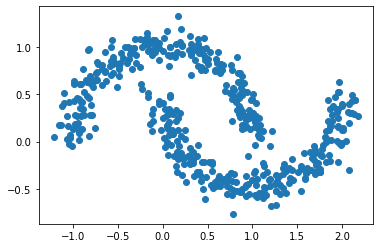

In [195]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

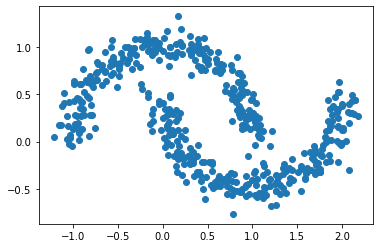

In [196]:
# your code here

clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

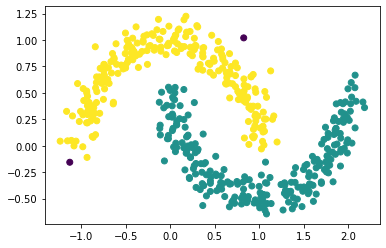

In [183]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [ ]:
# your code here

Или хотя бы что-нибудь такое: 

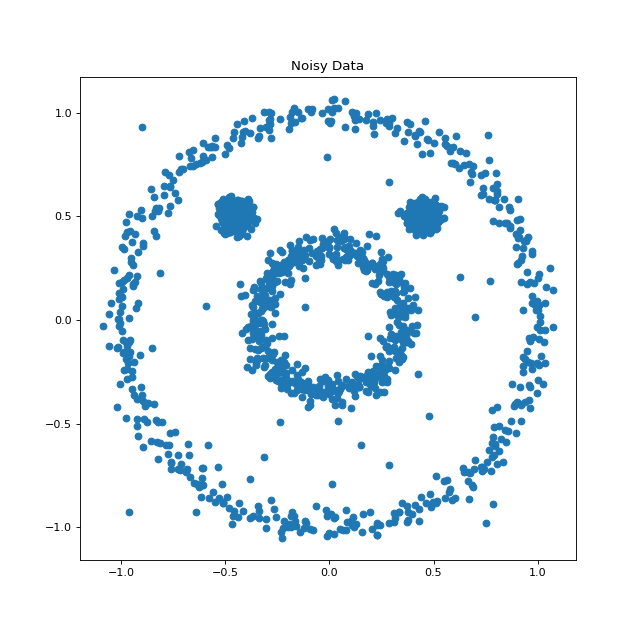

In [ ]:
# your code here

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)